In [2]:
import pandas as pd
from lxml import etree
import matplotlib.pyplot as plt
import re
from datetime import datetime
import networkx as nx
from adjustText import adjust_text
import numpy as np
from netgraph import Graph
from pyvis.network import Network

## Read and Parse XML

In this section, we will process the XML file which contains the lecture series data. The processing of the data has the goal of structuring the information and enabling easy acess to datasets optimized and formatted for the network analysis. The specific steps of the data processing are as follows:

1. Parsing the XML
2. Extracting the data whilst mantaining its hierarchical structure (e.g., Lecture Series > Term > Lectures)
3. Storing the data in tabular forms (i.e. DataFrames) 

**1. Parsing the XML**



In [52]:
# read the xml file

idx_path = "dh-lecture-series.xml"

# parse xml
tree = etree.parse(idx_path)
root = tree.getroot()

# define namespaces
ns = {"tei": "http://www.tei-c.org/ns/1.0"}

**Structuring the data**

In the code block below four classes are defined. These classes define the structure of the objects, or information, we extract from the XML file and how they behave. 

In [74]:
class LectureSeries():
    
    def __init__(self, host, title, id):
        self.place = host
        self.title = title
        self.terms = []
        self.id = id
        


    def __repr__(self):
        return f"LectureSeries(id={self.id}, host={self.place}, title= '{self.title}')"
    
    def add_term(self, name, timespan, organizers, lst_id):
        new_term = LectureSeriesTerm(name,  timespan, organizers,lst_id)
        self.terms.append(new_term)
        return new_term
        

class LectureSeriesTerm():
    

    def __init__(self, name, timespan, organizers, lst_id):
        self.name = name
        self.data = {}
        self.timespan = timespan
        self.organizers = organizers
        self.lectures = []
        self.lst_id = lst_id
        

    
    def __repr__(self):
        return f"LectureSeriesTerm (id={self.lst_id}, name={self.name}, timespan={self.timespan}, organizers={self.organizers})"
    

    def add_lecture(self, title, date, abstract, discipline, keywords, realization, speakers, lid):
        new_lecture = Lecture(title, date, abstract, discipline, keywords, realization, speakers,lid)
        self.lectures.append(new_lecture)
        return new_lecture


class Lecture():
    
    def __init__(self, title, date, abstract, discipline, keywords, realization, speakers, lid):
        self.title = title
        self.date = date
        self.abstract = abstract
        self.discipline = discipline
        self.keywords = keywords
        self.realization = realization
        self.speakers = speakers
        self.id = lid
        
        

    def __repr__(self):
        return f"Lecture (id={self.id}, title='{self.title}', speakers={self.speakers})"
    

class Person():
    

    def __init__(self, id, firstname, lastname, sex):
        self.id = id
        self.firstname = firstname
        self.lastname = lastname
        self.sex = sex
        self.affiliations = {}


    def add_affiliations(self, new_affiliations):
        self.affiliations.update(new_affiliations)

    def __repr__(self):
        return f"Person (id={self.id}, sex={self.sex}, affiliations={self.affiliations})"


**2. Extracting the data**

To extract the data, we identify the hierarchical level where the data is stored in the XML file and iterate through all repeating instances of a unit, collecting all respective metadata. All the data for the people (speakers and organizers alike) is stored within a <listPerson> element, each person as a <person> unit. We then locate the <listPerson> level and iterate through all <person> elements, collecting all relevant information and storing it according to the predefined Person class.

In [83]:
allpeople= []

for person in root.xpath("//tei:listPerson", namespaces=ns)[0]:
    
    sex = person.get("gender")
    id = person.get("{http://www.w3.org/XML/1998/namespace}id")
    
    firstname = person.xpath("./tei:name/tei:forename", namespaces=ns)[0].text
    lastname = person.xpath("./tei:name/tei:surname", namespaces=ns)[0].text
    namelink = person.xpath("./tei:name/tei:nameLink", namespaces=ns)
    
    if namelink:
        
        lastname = f"{namelink[0].text} {lastname}"

    newperson = Person(id,firstname,lastname,sex)
    allpeople.append(newperson)

people_byid = {person.id: person for person in allpeople}

In [84]:
people_byid['sperberg-mc-queen_michael']

Person (id=sperberg-mc-queen_michael, sex=None, affiliations={})

We do the same for the lecture series. Here, however, the complexity is higher since the targeted information cascades within the <listEvent> element.

In [85]:
all_lecture_series = []
for series in root.xpath("//tei:listEvent/tei:event", namespaces=ns):
    host = series.get("where").replace("#","")
    ls_id = series.get("{http://www.w3.org/XML/1998/namespace}id")
    title = series.find("tei:eventName", namespaces=ns).text
    title = re.sub(r"\s+"," ", title)
    
    lecture_series = LectureSeries(host, title, ls_id)
    
    terms = series.findall("tei:event[@type='lecture-series-term']", namespaces=ns)
    # print(f"{host}:\n")

    for term in terms:
        
        # timespan
        time_i = datetime.strptime(term.get("from"), "%Y-%m")
        time_f = datetime.strptime(term.get("to"), "%Y-%m")
        timespan = (time_i, time_f)
        lst_id = series.get("{http://www.w3.org/XML/1998/namespace}id")

        # organizers
        org = term.find("tei:org[@role='organizer']", namespaces=ns).get("corresp").replace("#","").split(" ")

        # name
        name = term.find("tei:eventName", namespaces=ns).text
        try:
            name = re.sub(r"\s+"," ", name)
        except TypeError:
            name= 'noname'
        
        lecture_series_term = lecture_series.add_term(name, timespan, org, lst_id)
        
        talks = term.findall("tei:event[@type='lecture']", namespaces=ns)

        for talk in talks:
            """realization"""
            #date
            date = datetime.strptime(talk.get("when"), "%Y-%m-%d")

            #id
            lid = talk.get("{http://www.w3.org/XML/1998/namespace}id")
            
            # title
            title = talk.find("tei:eventName", namespaces=ns).text
            try:
                title = re.sub(r"\s+"," ", title)
            except TypeError:
                title= 'notitle'
            
            # abstract
            abstract = talk.find("tei:note[@type='abstract']",namespaces=ns).text
            try:
                abstract = re.sub(r"\s+"," ", abstract)
            except TypeError:
                abstract= 'noabstract'
            
            # disciplines
            notes = talk.find("tei:note[@type='keywords']",namespaces=ns)
            
            try:
                discipline = notes.find("tei:term[@type='discipline']",namespaces=ns).get("corresp").replace("#","").split(" ")
            except AttributeError:
                discipline = ['nodisciplines']
            
            # keywords - tadirah
            try:
                keywords = notes.find("tei:term[@type='topic']",namespaces=ns).get("corresp")
                if keywords is not None:
                    keywords = re.sub(r"\s+"," ", keywords).replace("https://vocabs.dariah.eu/tadirah/","")
                    keywords = keywords.split()
            except AttributeError:
                keywords = ["no keywords"]

            # speakers

            list_person= talk.find("tei:listPerson", namespaces=ns)

            presenters = []

            for person in list_person:
                person_name = person.get("corresp")
                if person_name is None:
                    person_name = "unknown"
                else:
                    person_name= person_name.replace("#", "")
                person_affiliation = person.find("tei:affiliation", namespaces=ns)
                try:
                    person_affiliation = person_affiliation.get("corresp").replace("#", "")
                except AttributeError:
                    person_affiliation = 'unknown'
                
                presenters.append({person_name : person_affiliation})
                
                if person_name in people_byid:
                    p = people_byid[person_name]
                    p.add_affiliations({date.year:person_affiliation})
                else:
                    print(f"⚠️ Warning: Person '{person_name}' not found in people_byid")

                    sex = "unknown"
                    try:
                        firstname = person_name.split("_")[1]
                        lastname = person_name.split("_")[0]
                    except IndexError:
                        firstname = "unknown"
                        lastname = "unknown"

                    newperson = Person(person_name,firstname,lastname,sex)
                    allpeople.append(newperson)
                    people_byid[person_name] = newperson
                    newperson.add_affiliations({date.year:person_affiliation})        
            
            
            # realization

            realization_info = talk.find("tei:note[@type='realization']", namespaces=ns)

            realization = {}

            for info in realization_info:
                realization[info.get("type")] = info.text
            
            lecture = lecture_series_term.add_lecture(title, date,abstract,discipline,keywords,realization,presenters,lid)
    
    all_lecture_series.append(lecture_series)
            

⚠️ Warning: Person 'donadelli_giovanni' not found in people_byid
⚠️ Warning: Person 'buzzoni_marina' not found in people_byid
⚠️ Warning: Person 'abiven_karine' not found in people_byid
⚠️ Warning: Person 'bartz_alexandre' not found in people_byid
⚠️ Warning: Person 'saignol_come' not found in people_byid
⚠️ Warning: Person 'borgna_alice' not found in people_byid
⚠️ Warning: Person 'da-costa_georges' not found in people_byid
⚠️ Warning: Person 'hentschel_frank' not found in people_byid
⚠️ Warning: Person 'wübbena_thorsten' not found in people_byid
⚠️ Warning: Person 'heusinger_klaus-von' not found in people_byid
⚠️ Warning: Person 'niknia_massoomeh' not found in people_byid
⚠️ Warning: Person 'hess_mona' not found in people_byid
⚠️ Warning: Person 'kramer_iris' not found in people_byid
⚠️ Warning: Person 'anne_ferger' not found in people_byid
⚠️ Warning: Person 'nantke_julia' not found in people_byid
⚠️ Warning: Person 'roeder_torsten' not found in people_byid
⚠️ Warning: Person 'bermú

**3. Storing the data in DataFrames**

We now structure the collected data in tabular format in a DataFrame. This makes it easier to manipulate and process the data in preparation for analysis as well as calculating frequencies and generating visualizations.

In [86]:
df = pd.DataFrame({'SeriesId':[],
                  'SeriesPlace':[],
                  'SeriesTitle':[],
                  'TermId':[],
                  'TermTimespan':[],
                  'TermOrganizers':[],
                  'LectureId':[],
                  'LectureTitle':[],
                  'LectureSpeaker':[]
                  })

for i in all_lecture_series:
    
    for t in i.terms:
        for o in t.organizers:
            
            for l in t.lectures:
                
                for s in l.speakers:
                    for key, value in s.items():
                        # print(i.id,i.place,i.title,t.id,t.timespan,o,l.id,l.title,f"{key} ({value})")
                        df.loc[len(df)] = [i.id,
                                           i.place,
                                           i.title,
                                           t.lst_id,
                                           str(t.timespan),
                                           o,
                                           l.id,
                                           l.title,
                                           f"{key} ({value})"]

In [87]:
df.head()

SeriesId SeriesPlace                         SeriesTitle TermId  \
0      ls1      padova  Doing digital humanities @ DiSSGeA    ls1   
1      ls1      padova  Doing digital humanities @ DiSSGeA    ls1   
2      ls1      padova  Doing digital humanities @ DiSSGeA    ls1   
3      ls1      padova  Doing digital humanities @ DiSSGeA    ls1   
4      ls1      padova  Doing digital humanities @ DiSSGeA    ls1   

                                        TermTimespan  TermOrganizers  \
0  (datetime.datetime(2020, 10, 1, 0, 0), datetim...  biasiori_lucio   
1  (datetime.datetime(2020, 10, 1, 0, 0), datetim...  biasiori_lucio   
2  (datetime.datetime(2020, 10, 1, 0, 0), datetim...  biasiori_lucio   
3  (datetime.datetime(2020, 10, 1, 0, 0), datetim...  biasiori_lucio   
4  (datetime.datetime(2020, 10, 1, 0, 0), datetim...  biasiori_lucio   

   LectureId                                       LectureTitle  \
0  ls1_t1_l1                            Distant Reading Austria   
1  ls1_t1_l2  Valorizzazione e comunicazione digitale del pa...   
2  ls1_t1_l3  Local Literature Studies and Historical GIS Pr...   
3  ls1_t1_l4  Da NodeGoat ad ArcGis: l’interoperabilità dei ...   
4  ls1_t1_l5  Il progetto CoDato e i Codices Vossiani Latini...   

                                      LectureSpeaker  
0                          wallnig_thomas (uni-wien)  
1  donadelli_giovanni (uni-padova museum-uni-padova)  
2                          xie_shi (uni-sun-yat-sen)  
3                         orlandi_marco (uni-padova)  
4                         elice_martina (uni-padova)

In [88]:
# display characteristics of dataframe
df.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 2799 entries, 0 to 2798
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   SeriesId        2799 non-null   object
 1   SeriesPlace     2799 non-null   object
 2   SeriesTitle     2799 non-null   object
 3   TermId          2799 non-null   object
 4   TermTimespan    2799 non-null   object
 5   TermOrganizers  2799 non-null   object
 6   LectureId       2799 non-null   object
 7   LectureTitle    2799 non-null   object
 8   LectureSpeaker  2799 non-null   object
dtypes: object(9)
memory usage: 218.7+ KB


In [91]:
df.to_csv("Data/lectureseries_tabular.csv", sep="\t", encoding="utf-8", index=False)

In [226]:
with open("lecture-series-completed.txt", "r", encoding="utf-8") as f:
    content = f.read().strip() 
    ls_completed = content.split(',')

df = df[df['SeriesId'].isin(ls_completed)]
df

SeriesId        SeriesPlace                             SeriesTitle  \
0         ls1             padova      Doing digital humanities @ DiSSGeA   
1         ls1             padova      Doing digital humanities @ DiSSGeA   
2         ls1             padova      Doing digital humanities @ DiSSGeA   
3         ls1             padova      Doing digital humanities @ DiSSGeA   
4         ls1             padova      Doing digital humanities @ DiSSGeA   
...       ...                ...                                     ...   
2741     ls30  dublin birmingham  Trust and Authority in the Digital Age   
2742     ls30  dublin birmingham  Trust and Authority in the Digital Age   
2743     ls30  dublin birmingham  Trust and Authority in the Digital Age   
2744     ls30  dublin birmingham  Trust and Authority in the Digital Age   
2745     ls30  dublin birmingham  Trust and Authority in the Digital Age   

     TermId                                       TermTimespan  \
0       ls1  (datetime.datetime(2020, 10, 1, 0, 0), datetim...   
1       ls1  (datetime.datetime(2020, 10, 1, 0, 0), datetim...   
2       ls1  (datetime.datetime(2020, 10, 1, 0, 0), datetim...   
3       ls1  (datetime.datetime(2020, 10, 1, 0, 0), datetim...   
4       ls1  (datetime.datetime(2020, 10, 1, 0, 0), datetim...   
...     ...                                                ...   
2741   ls30  (datetime.datetime(2021, 5, 1, 0, 0), datetime...   
2742   ls30  (datetime.datetime(2021, 5, 1, 0, 0), datetime...   
2743   ls30  (datetime.datetime(2021, 5, 1, 0, 0), datetime...   
2744   ls30  (datetime.datetime(2021, 5, 1, 0, 0), datetime...   
2745   ls30  (datetime.datetime(2021, 5, 1, 0, 0), datetime...   

      TermOrganizers   LectureId  \
0     biasiori_lucio   ls1_t1_l1   
1     biasiori_lucio   ls1_t1_l2   
2     biasiori_lucio   ls1_t1_l3   
3     biasiori_lucio   ls1_t1_l4   
4     biasiori_lucio   ls1_t1_l5   
...              ...         ...   
2741    abbott_helen  ls30_t1_l2   
2742    abbott_helen  ls30_t1_l3   
2743     ward_aengus  ls30_t1_l1   
2744     ward_aengus  ls30_t1_l2   
2745     ward_aengus  ls30_t1_l3   

                                           LectureTitle  \
0                               Distant Reading Austria   
1     Valorizzazione e comunicazione digitale del pa...   
2     Local Literature Studies and Historical GIS Pr...   
3     Da NodeGoat ad ArcGis: l’interoperabilità dei ...   
4     Il progetto CoDato e i Codices Vossiani Latini...   
...                                                 ...   
2741  Uncertainty in Manuscript Technologies and the...   
2742   Trust, Authority and the Automation of Expertise   
2743  The Illusion of Grandeur: Trust and Belief in ...   
2744  Uncertainty in Manuscript Technologies and the...   
2745   Trust, Authority and the Automation of Expertise   

                                         LectureSpeaker  
0                             wallnig_thomas (uni-wien)  
1     donadelli_giovanni (uni-padova museum-uni-padova)  
2                             xie_shi (uni-sun-yat-sen)  
3                            orlandi_marco (uni-padova)  
4                            elice_martina (uni-padova)  
...                                                 ...  
2741                     treharne_elaine (uni-stanford)  
2742                   bassett_caroline (uni-cambridge)  
2743                           sanderson_rob (uni-yale)  
2744                     treharne_elaine (uni-stanford)  
2745                   bassett_caroline (uni-cambridge)  

[763 rows x 9 columns]

In [89]:
person_dict= {person.id: person for person in allpeople}

In [90]:
person_dict

{'sperberg-mc-queen_michael': Person (id=sperberg-mc-queen_michael, sex=None, affiliations={2020: 'black-mesa-technologies'}),
 'bloomfield_camille': Person (id=bloomfield_camille, sex=None, affiliations={2023: 'uni-paris-cite'}),
 'tadier_elsa': Person (id=tadier_elsa, sex=None, affiliations={2023: 'uni-paris-cite'}),
 'ysebaert_ronan': Person (id=ysebaert_ronan, sex=None, affiliations={2023: 'uni-paris-cite'}),
 'flipo_fabrice': Person (id=flipo_fabrice, sex=None, affiliations={2023: 'uni-paris-cite'}),
 'ritz_olivier': Person (id=ritz_olivier, sex=None, affiliations={2022: 'uni-paris-cite'}),
 'stoehr_thierry': Person (id=stoehr_thierry, sex=None, affiliations={2022: 'uni-paris-cite'}),
 'poulain_pierre': Person (id=poulain_pierre, sex=None, affiliations={2022: 'uni-paris-cite'}),
 'goerres_daniel': Person (id=goerres_daniel, sex=None, affiliations={2024: 'fh-koeln'}),
 'klusik-eckert_jacqueline': Person (id=klusik-eckert_jacqueline, sex=None, affiliations={2023: 'uni-duesseldorf'})

In [94]:
# import pandas as pd

# Step 1: Prepare data for DataFrame
data_list = []

for person in person_dict.values():  # Iterate over the dictionary of Person objects
    for year, institution in person.affiliations.items():
        data_list.append({
            "Person ID": person.id,
            "First Name": person.firstname,
            "Last Name": person.lastname,
            "Sex": person.sex,
            "Year": year,
            "Institution": institution
        })

# Step 2: Convert to DataFrame
df_people = pd.DataFrame(data_list)



In [95]:
df_people[df_people['Person ID'].str.contains("henny")]

Person ID First Name      Last Name   Sex  Year    Institution
650  henny-krahmer_ulrike     Ulrike  Henny-Krahmer  None  2017  uni-wuerzburg
651  henny-krahmer_ulrike     Ulrike  Henny-Krahmer  None  2022    uni-rostock
652  henny-krahmer_ulrike     Ulrike  Henny-Krahmer  None  2023    uni-rostock
653  henny-krahmer_ulrike     Ulrike  Henny-Krahmer  None  2025    uni-rostock

In [ ]:
df_people = df_people.drop(
    df_people[(df_people['Person ID'] == "unknown") | (df_people['Person ID'] == "")].index
)

df_people

Person ID First Name         Last Name      Sex  Year  \
0     sperberg-mc-queen_michael    Michael  Sperberg-McQueen     None  2020   
1            bloomfield_camille    Camille        Bloomfield     None  2023   
2                   tadier_elsa       Elsa            Tadier     None  2023   
3                ysebaert_ronan      Ronan          Ysebaert     None  2023   
4                 flipo_fabrice    Fabrice             Flipo     None  2023   
...                         ...        ...               ...      ...   ...   
1038              pfister_eugen      eugen           pfister  unknown  2023   
1039                kato_hiloko     hiloko              kato  unknown  2023   
1040               wild_larissa    larissa              wild  unknown  2023   
1041             niklas_jedrzej    jedrzej            niklas  unknown  2025   
1042         ros-munoz_salvador   salvador         ros-munoz  unknown  2024   

                                Institution  
0                   black-mesa-technologies  
1                            uni-paris-cite  
2                            uni-paris-cite  
3                            uni-paris-cite  
4                            uni-paris-cite  
...                                     ...  
1038                               uni-bern  
1039                 uni-zuerich fh-zuerich  
1040                uni-lausanne fh-zuerich  
1041                          uni-cambridge  
1042  uni-nacional-de-educacion-a-distancia  

[1043 rows x 6 columns]

In [102]:
df_people.to_csv("Data/people_tabular.csv", sep="\t", encoding="utf-8", index=False)

In [ ]:
person_institution_df = df_people[['Person ID','Institution','Year']].copy()
person_institution_df = person_institution_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
person_institution_df['Institution'] = person_institution_df['Institution'].str.split()

# 'explode' institution column to create one row per institution
person_institution_df = person_institution_df.explode('Institution').reset_index(drop=True)
person_institution_df = person_institution_df.drop_duplicates(subset=["Person ID", "Institution"], keep='first')
person_institution_df.sort_values(by='Person ID')



Person ID    Institution  Year
315                 abel_stefan       uni-bern  2021
1030              abiven_karine   uni-sorbonne  2021
360               achimova_asya  uni-tuebingen  2023
633   acquavella-rauch_stefanie      uni-mainz  2021
92          afanador_maria-jose      uni-andes  2024
...                         ...            ...   ...
444         zimmermann_dorothea    library-eth  2023
490           zinsmeister_heike    uni-hamburg  2022
367             zirker_angelika  uni-tuebingen  2023
585             zloch_stephanie    uni-dresden  2023
249               zuanni_chiara       uni-graz  2020

[944 rows x 3 columns]

In [105]:
person_institution_df[person_institution_df['Person ID'].str.contains("fernanda")]

Person ID    Institution  Year
646  alvares-freire_fernanda    uni-rostock  2023
648  alvares-freire_fernanda  uni-darmstadt  2024

In [106]:
has_duplicates = person_institution_df.duplicated(subset=["Person ID", "Institution"]).any()
print(has_duplicates)  # True if duplicates exist, False otherwise


False


In [107]:
person_institution_df.to_csv("Data/peopleinstitution_tabular.csv", sep="\t", encoding="utf-8", index=False)

## Network 1: Organizers-Speakers

 'uni-london-kcl',
 'uni-padova',
 'uni-tuebingen',
 'vedph'

In [108]:
df.head()

SeriesId SeriesPlace                         SeriesTitle TermId  \
0      ls1      padova  Doing digital humanities @ DiSSGeA    ls1   
1      ls1      padova  Doing digital humanities @ DiSSGeA    ls1   
2      ls1      padova  Doing digital humanities @ DiSSGeA    ls1   
3      ls1      padova  Doing digital humanities @ DiSSGeA    ls1   
4      ls1      padova  Doing digital humanities @ DiSSGeA    ls1   

                                        TermTimespan  TermOrganizers  \
0  (datetime.datetime(2020, 10, 1, 0, 0), datetim...  biasiori_lucio   
1  (datetime.datetime(2020, 10, 1, 0, 0), datetim...  biasiori_lucio   
2  (datetime.datetime(2020, 10, 1, 0, 0), datetim...  biasiori_lucio   
3  (datetime.datetime(2020, 10, 1, 0, 0), datetim...  biasiori_lucio   
4  (datetime.datetime(2020, 10, 1, 0, 0), datetim...  biasiori_lucio   

   LectureId                                       LectureTitle  \
0  ls1_t1_l1                            Distant Reading Austria   
1  ls1_t1_l2  Valorizzazione e comunicazione digitale del pa...   
2  ls1_t1_l3  Local Literature Studies and Historical GIS Pr...   
3  ls1_t1_l4  Da NodeGoat ad ArcGis: l’interoperabilità dei ...   
4  ls1_t1_l5  Il progetto CoDato e i Codices Vossiani Latini...   

                                      LectureSpeaker  
0                          wallnig_thomas (uni-wien)  
1  donadelli_giovanni (uni-padova museum-uni-padova)  
2                          xie_shi (uni-sun-yat-sen)  
3                         orlandi_marco (uni-padova)  
4                         elice_martina (uni-padova)

In [119]:
people_net = df[['TermOrganizers','LectureSpeaker','SeriesId','LectureId']]
people_net = people_net[~people_net['TermOrganizers'].str.contains("uni-") & ~people_net['TermOrganizers'].str.contains("vedph")]
people_net.rename(columns={'LectureId': 'EdgeId'}, inplace=True)
people_net[['speaker','affiliation']] = people_net['LectureSpeaker'].str.split('(', expand=True)
people_net['affiliation'] = people_net['affiliation'].str.replace(")","")
people_net['speaker'] = people_net['speaker'].str.replace("#","").str.rstrip()
people_net['TermOrganizers'] = people_net['TermOrganizers'].str.rstrip()
people_net = people_net[people_net['speaker'] != 'unknown']
people_net = people_net[people_net['speaker'] != '']

people_net


TermOrganizers                                     LectureSpeaker  \
0       biasiori_lucio                          wallnig_thomas (uni-wien)   
1       biasiori_lucio  donadelli_giovanni (uni-padova museum-uni-padova)   
2       biasiori_lucio                          xie_shi (uni-sun-yat-sen)   
3       biasiori_lucio                         orlandi_marco (uni-padova)   
4       biasiori_lucio                         elice_martina (uni-padova)   
...                ...                                                ...   
2784     fridlund_mats                      björkin_mats (uni-gothenburg)   
2785  ingvarsson_jonas                       lamberti_elena (uni-bologna)   
2787     fridlund_mats                       lamberti_elena (uni-bologna)   
2789    pestana_olivia              liu_ying-hsang (uni-southern-denmark)   
2794    golub_koraljka              liu_ying-hsang (uni-southern-denmark)   

     SeriesId      EdgeId             speaker                   affiliation  
0         ls1   ls1_t1_l1      wallnig_thomas                      uni-wien  
1         ls1   ls1_t1_l2  donadelli_giovanni  uni-padova museum-uni-padova  
2         ls1   ls1_t1_l3             xie_shi               uni-sun-yat-sen  
3         ls1   ls1_t1_l4       orlandi_marco                    uni-padova  
4         ls1   ls1_t1_l5       elice_martina                    uni-padova  
...       ...         ...                 ...                           ...  
2784     ls33  ls33_t1_l8        björkin_mats                uni-gothenburg  
2785     ls33  ls33_t2_l1      lamberti_elena                   uni-bologna  
2787     ls33  ls33_t2_l1      lamberti_elena                   uni-bologna  
2789     ls34  ls34_t1_l1      liu_ying-hsang          uni-southern-denmark  
2794     ls34  ls34_t1_l1      liu_ying-hsang          uni-southern-denmark  

[2789 rows x 6 columns]

In [120]:
people_net['speaker'].value_counts()

speaker
thomas_christian              33
sahle_patrick                 27
tuerkoglu_enes                27
haaf_susanne                  24
dumont_stefan                 24
                              ..
drucker_johanna                1
del-bosque-gonzalez_isabel     1
coma-quintana_laia             1
rodriguez-ortega_nuria         1
boadas_sonia                   1
Name: count, Length: 852, dtype: int64

In [121]:
people_net.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2789 entries, 0 to 2794
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   TermOrganizers  2789 non-null   object
 1   LectureSpeaker  2789 non-null   object
 2   SeriesId        2789 non-null   object
 3   EdgeId          2789 non-null   object
 4   speaker         2789 non-null   object
 5   affiliation     2789 non-null   object
dtypes: object(6)
memory usage: 152.5+ KB


In [122]:
people_list = list(people_net['TermOrganizers'].str.rstrip()) + list(people_net['speaker'].str.rstrip())
people_list = list(set(people_list))
people_list.remove("...")
print(len(people_list))

887


In [123]:
"..." in people_list

False

In [155]:
# people_net.to_csv("Data/organizers-speakers_edges.csv", sep="\t", encoding="utf-8", index=False)
people_net = pd.read_csv("Data/organizers-speakers_edges.csv", sep="\t", encoding="utf-8")

In [156]:
people_net

TermOrganizers                                     LectureSpeaker  \
0       biasiori_lucio                          wallnig_thomas (uni-wien)   
1       biasiori_lucio  donadelli_giovanni (uni-padova museum-uni-padova)   
2       biasiori_lucio                          xie_shi (uni-sun-yat-sen)   
3       biasiori_lucio                         orlandi_marco (uni-padova)   
4       biasiori_lucio                         elice_martina (uni-padova)   
...                ...                                                ...   
2784     fridlund_mats                      björkin_mats (uni-gothenburg)   
2785  ingvarsson_jonas                       lamberti_elena (uni-bologna)   
2786     fridlund_mats                       lamberti_elena (uni-bologna)   
2787    pestana_olivia              liu_ying-hsang (uni-southern-denmark)   
2788    golub_koraljka              liu_ying-hsang (uni-southern-denmark)   

     SeriesId      EdgeId             speaker                   affiliation  
0         ls1   ls1_t1_l1      wallnig_thomas                      uni-wien  
1         ls1   ls1_t1_l2  donadelli_giovanni  uni-padova museum-uni-padova  
2         ls1   ls1_t1_l3             xie_shi               uni-sun-yat-sen  
3         ls1   ls1_t1_l4       orlandi_marco                    uni-padova  
4         ls1   ls1_t1_l5       elice_martina                    uni-padova  
...       ...         ...                 ...                           ...  
2784     ls33  ls33_t1_l8        björkin_mats                uni-gothenburg  
2785     ls33  ls33_t2_l1      lamberti_elena                   uni-bologna  
2786     ls33  ls33_t2_l1      lamberti_elena                   uni-bologna  
2787     ls34  ls34_t1_l1      liu_ying-hsang          uni-southern-denmark  
2788     ls34  ls34_t1_l1      liu_ying-hsang          uni-southern-denmark  

[2789 rows x 6 columns]

In [162]:
people_net = people_net[people_net['SeriesId'].isin(ls_completed)]
people_net

TermOrganizers                                     LectureSpeaker  \
0     biasiori_lucio                          wallnig_thomas (uni-wien)   
1     biasiori_lucio  donadelli_giovanni (uni-padova museum-uni-padova)   
2     biasiori_lucio                          xie_shi (uni-sun-yat-sen)   
3     biasiori_lucio                         orlandi_marco (uni-padova)   
4     biasiori_lucio                         elice_martina (uni-padova)   
...              ...                                                ...   
2741    abbott_helen                     treharne_elaine (uni-stanford)   
2742    abbott_helen                   bassett_caroline (uni-cambridge)   
2743     ward_aengus                           sanderson_rob (uni-yale)   
2744     ward_aengus                     treharne_elaine (uni-stanford)   
2745     ward_aengus                   bassett_caroline (uni-cambridge)   

     SeriesId      EdgeId             speaker                   affiliation  
0         ls1   ls1_t1_l1      wallnig_thomas                      uni-wien  
1         ls1   ls1_t1_l2  donadelli_giovanni  uni-padova museum-uni-padova  
2         ls1   ls1_t1_l3             xie_shi               uni-sun-yat-sen  
3         ls1   ls1_t1_l4       orlandi_marco                    uni-padova  
4         ls1   ls1_t1_l5       elice_martina                    uni-padova  
...       ...         ...                 ...                           ...  
2741     ls30  ls30_t1_l2     treharne_elaine                  uni-stanford  
2742     ls30  ls30_t1_l3    bassett_caroline                 uni-cambridge  
2743     ls30  ls30_t1_l1       sanderson_rob                      uni-yale  
2744     ls30  ls30_t1_l2     treharne_elaine                  uni-stanford  
2745     ls30  ls30_t1_l3    bassett_caroline                 uni-cambridge  

[763 rows x 6 columns]

In [163]:
speaker_frequency = {}

for person in people_list:
    frequency = len(people_net[people_net['speaker'].str.contains(f"{person}")].drop_duplicates(subset=['EdgeId']))
    speaker_frequency[person] = frequency

In [164]:
speaker_frequency

{'rainsford_thomas': 0,
 'hinkel_sascha': 0,
 'vicent_naiara': 0,
 'arnold_frederik': 0,
 'backes_marianne': 1,
 'heilmann_jan': 2,
 'hercher_johannes': 1,
 'niknia_massoomeh': 0,
 'razniewski_simon': 1,
 'lohwasser_angelika': 0,
 'el-khatib_randa': 0,
 'carmo_ines-rebelo-do': 1,
 'angeletaki_alexandra': 1,
 'bernardini_federico': 1,
 'hoeltgen_stefan': 1,
 'pagliarini_enrico': 0,
 'bianchi_alessandra': 0,
 'block-berlitz_marco': 0,
 'eichert_stefan': 1,
 'koch_steffen': 0,
 'pichler_axel': 0,
 'van-erp_marieke': 1,
 'harm_volker': 0,
 'schulz_sarah': 0,
 'feuser_stefan': 0,
 'effinger_maria': 0,
 'vanautgaerden_alexandre': 0,
 'wuebbena_thorsten': 0,
 'passarotti_marco': 0,
 'hoffmann_moritz': 0,
 'greinert_cordula': 1,
 'burkart_lucas': 0,
 'saef_nasrin': 0,
 'lischke_lars': 0,
 'klammt_anne': 1,
 'meschini_federico': 0,
 'boschetti_federico': 1,
 'demleitner_adrian': 1,
 'dorn_nico': 0,
 'binnewitt_johanna': 0,
 'kellner_nils': 1,
 'keith_allison': 1,
 'heath_sebastian': 1,
 'hentsc

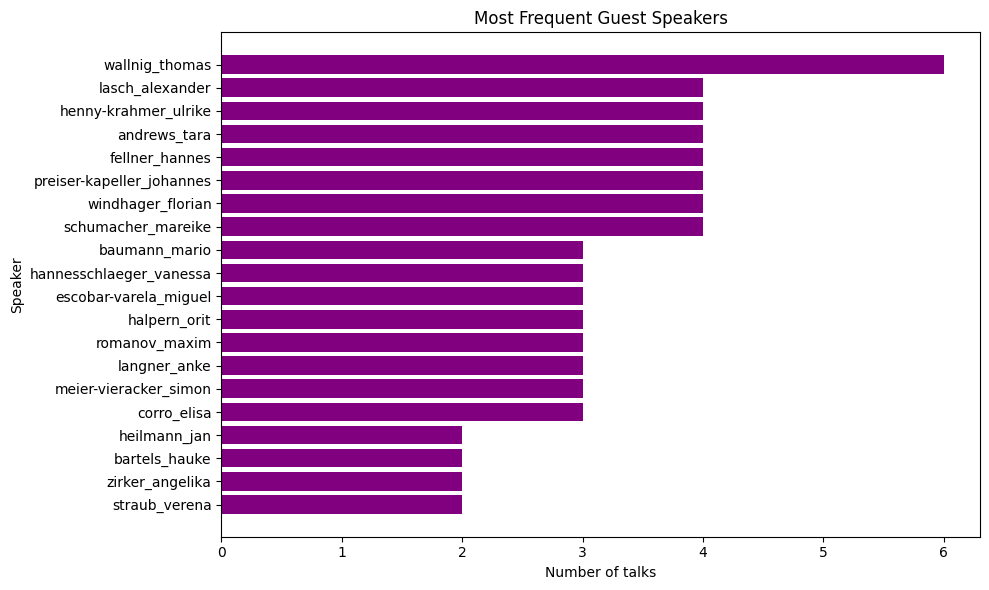

In [ ]:
sorted_speaker_frequency = sorted(speaker_frequency.items(), key=lambda x: x[1], reverse=True)[:20]
names, values = zip(*sorted_speaker_frequency)  # Unpack 
plt.figure(figsize=(10, 6))
plt.barh(names, values, color='purple')
plt.xlabel("Number of talks")
plt.ylabel("Speaker")
plt.title("Most Frequent Guest Speakers")
plt.gca().invert_yaxis()  # Highest value on top
plt.tight_layout()

plt.savefig("Data/Speaker_frequency.jpg")

plt.show()


Text(0.5, 1.0, 'People Network Graph')

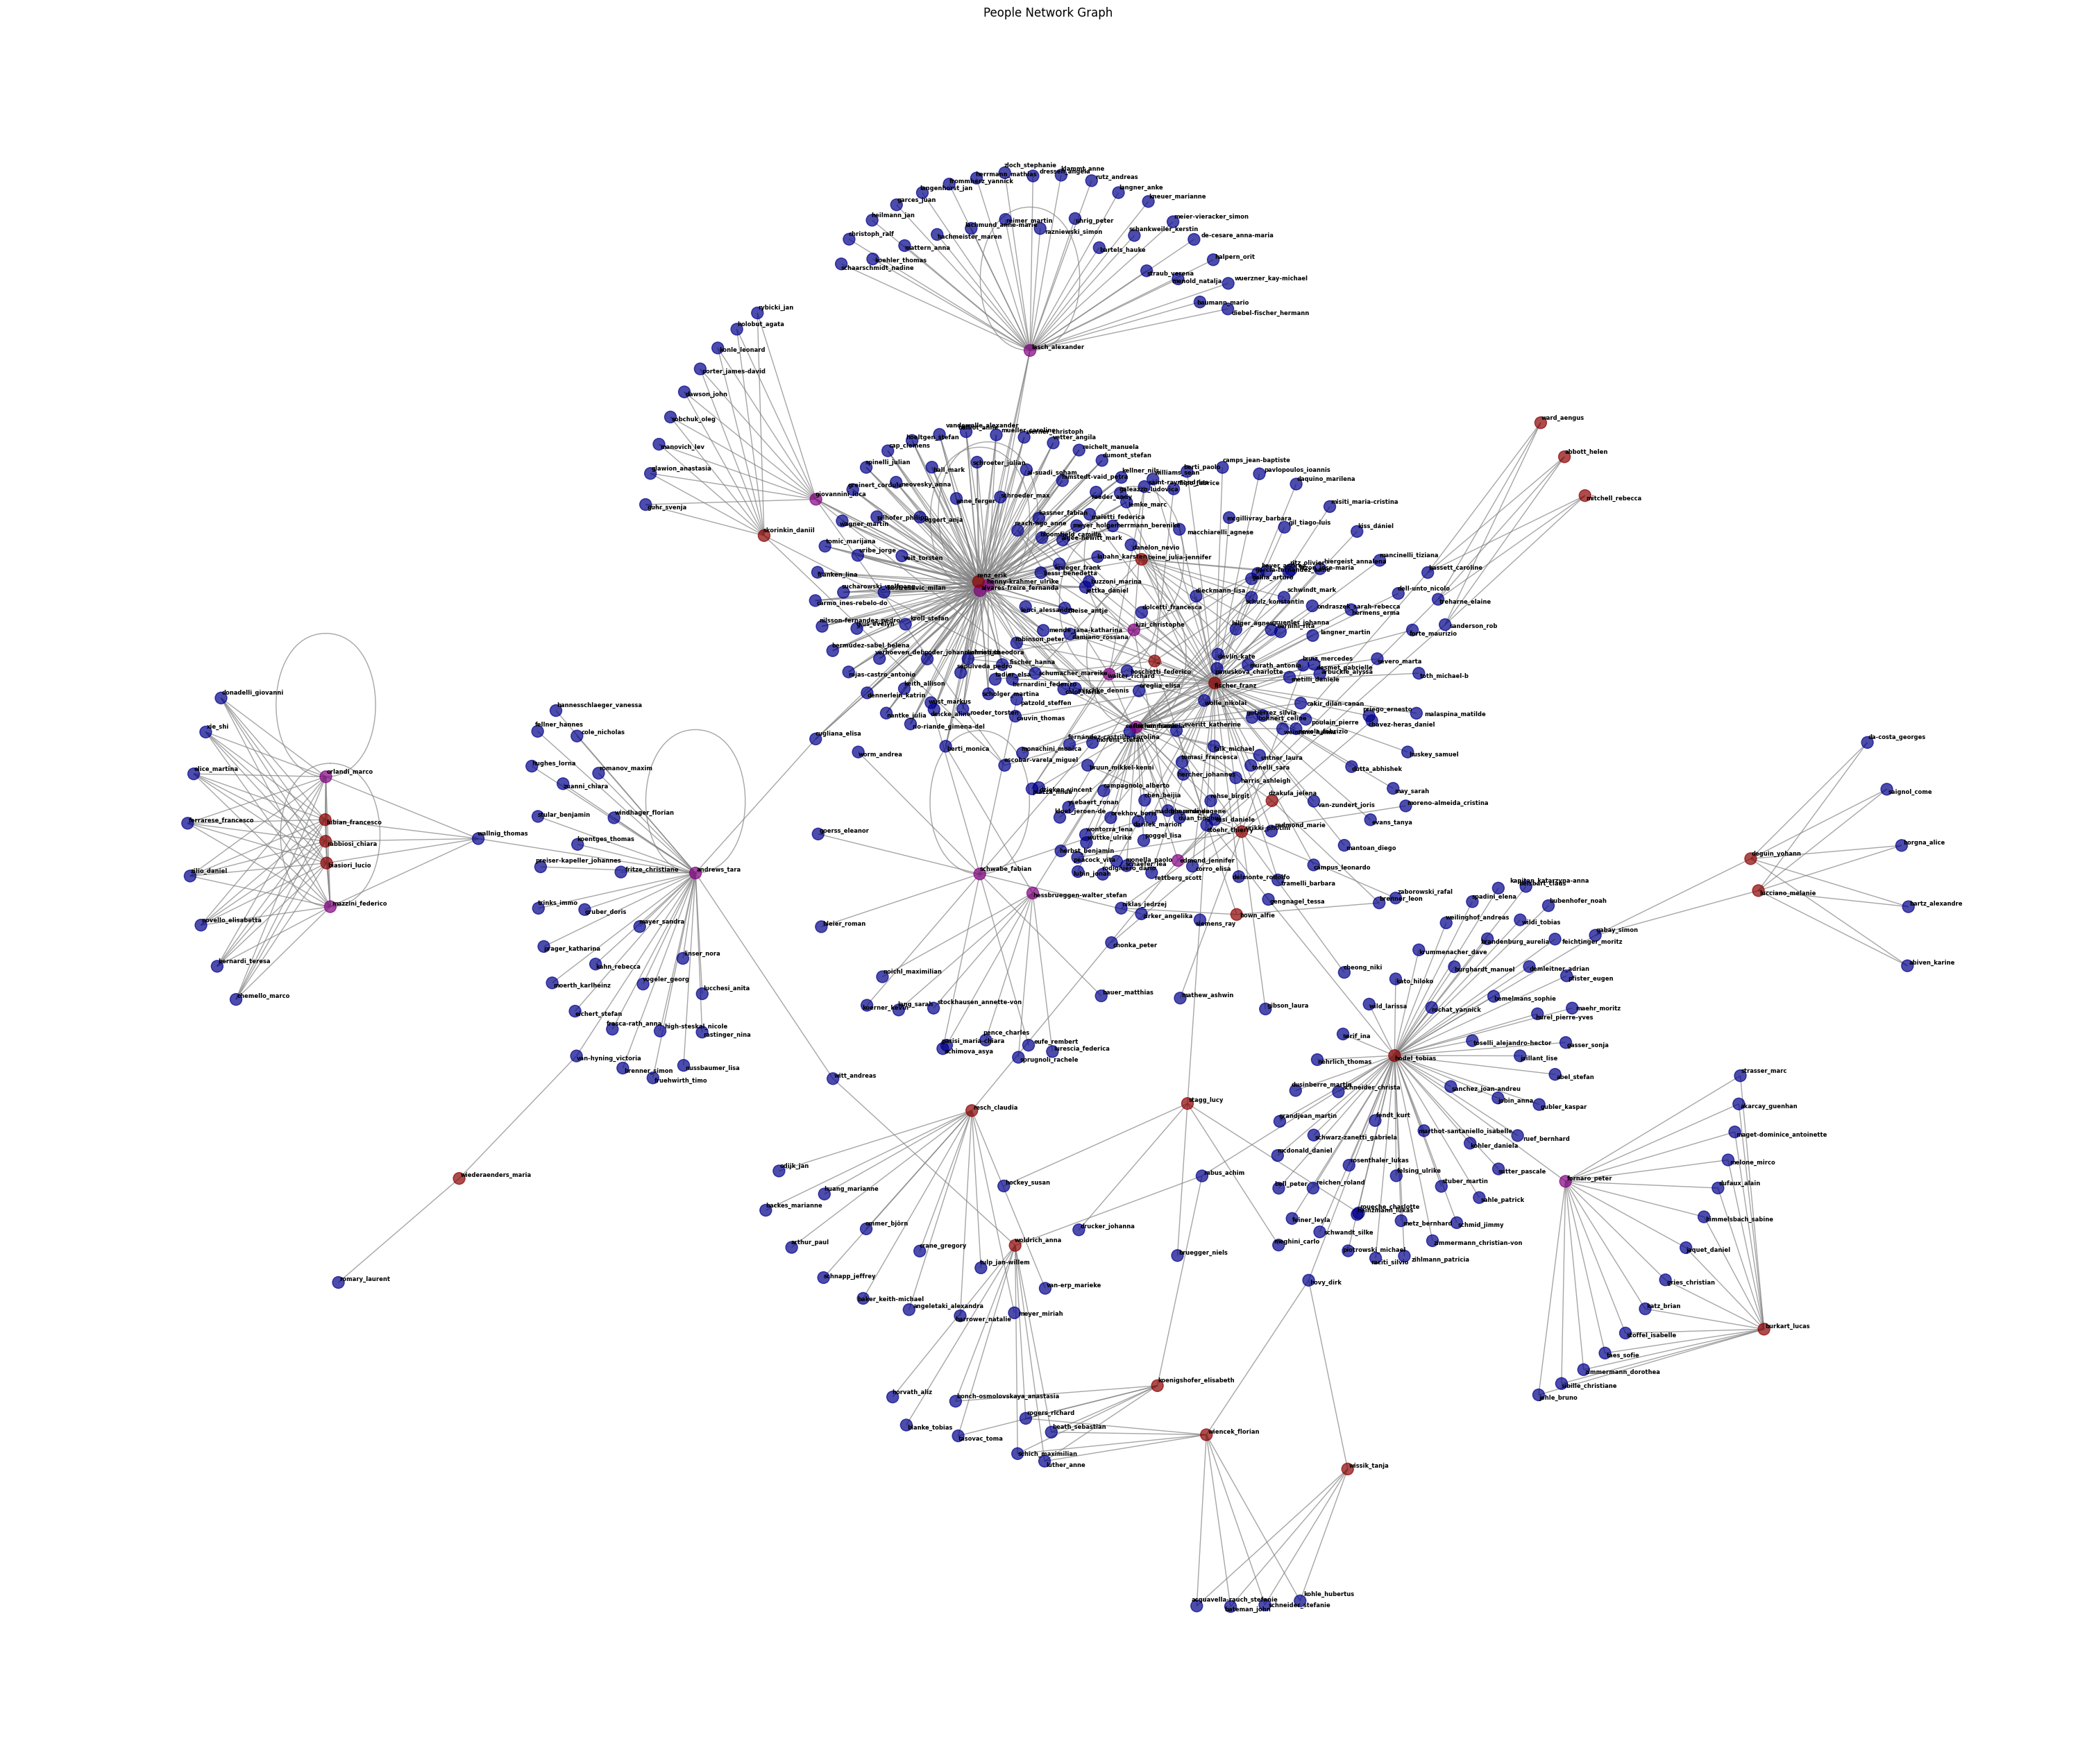

In [183]:
G = nx.Graph()

for _, row in people_net.iterrows():
    organizer = row['TermOrganizers']
    speaker = row['speaker']
    edge_id = row['EdgeId']

    G.add_node(organizer)
    G.add_node(speaker)

    G.add_edge(organizer, speaker, edge_id=edge_id)

node_colors = []
for node in G.nodes():
    is_organizer = node in people_net['TermOrganizers'].values
    is_speaker = node in people_net['speaker'].values

    if is_organizer and is_speaker:
        node_colors.append("purple")  # optional: overlap 
    elif is_organizer:
        node_colors.append("darkred")
    elif is_speaker:
        node_colors.append("darkblue")
    else:
        node_colors.append("gray")  # fallback - shouldn't happen!

plt.figure(figsize=(30, 25))
pos = nx.kamada_kawai_layout(G, scale=20.0)

nx.draw(G, 
        pos, 
        with_labels=False, 
        node_color=node_colors, 
        edge_color="gray", 
        node_size=150, 
        alpha=0.7)

text_labels = [plt.text(x, y, node, fontsize=6, fontweight='bold') for node, (x, y) in pos.items()]
adjust_text(text_labels)

plt.title("People Network Graph")
# plt.savefig("Data/people_network_graph.svg", bbox_inches="tight")
# plt.show()

In [ ]:
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

G = nx.relabel_nodes(G, lambda x: str(x).strip())

nt = Network(height='1000px', width='1000px', select_menu=True)
nt.from_nx(G)
nt.toggle_physics(False)


for node in nt.nodes:
    node['label'] = str(node['id'])

# minimal UI controls
nt.show_buttons(filter_=['physics'])

nt.show('Data/people_network.html',notebook=False)  # Opens in browser

Nodes: 426
Edges: 666
people_network.html


graph of organizers-speakers with degree visualization

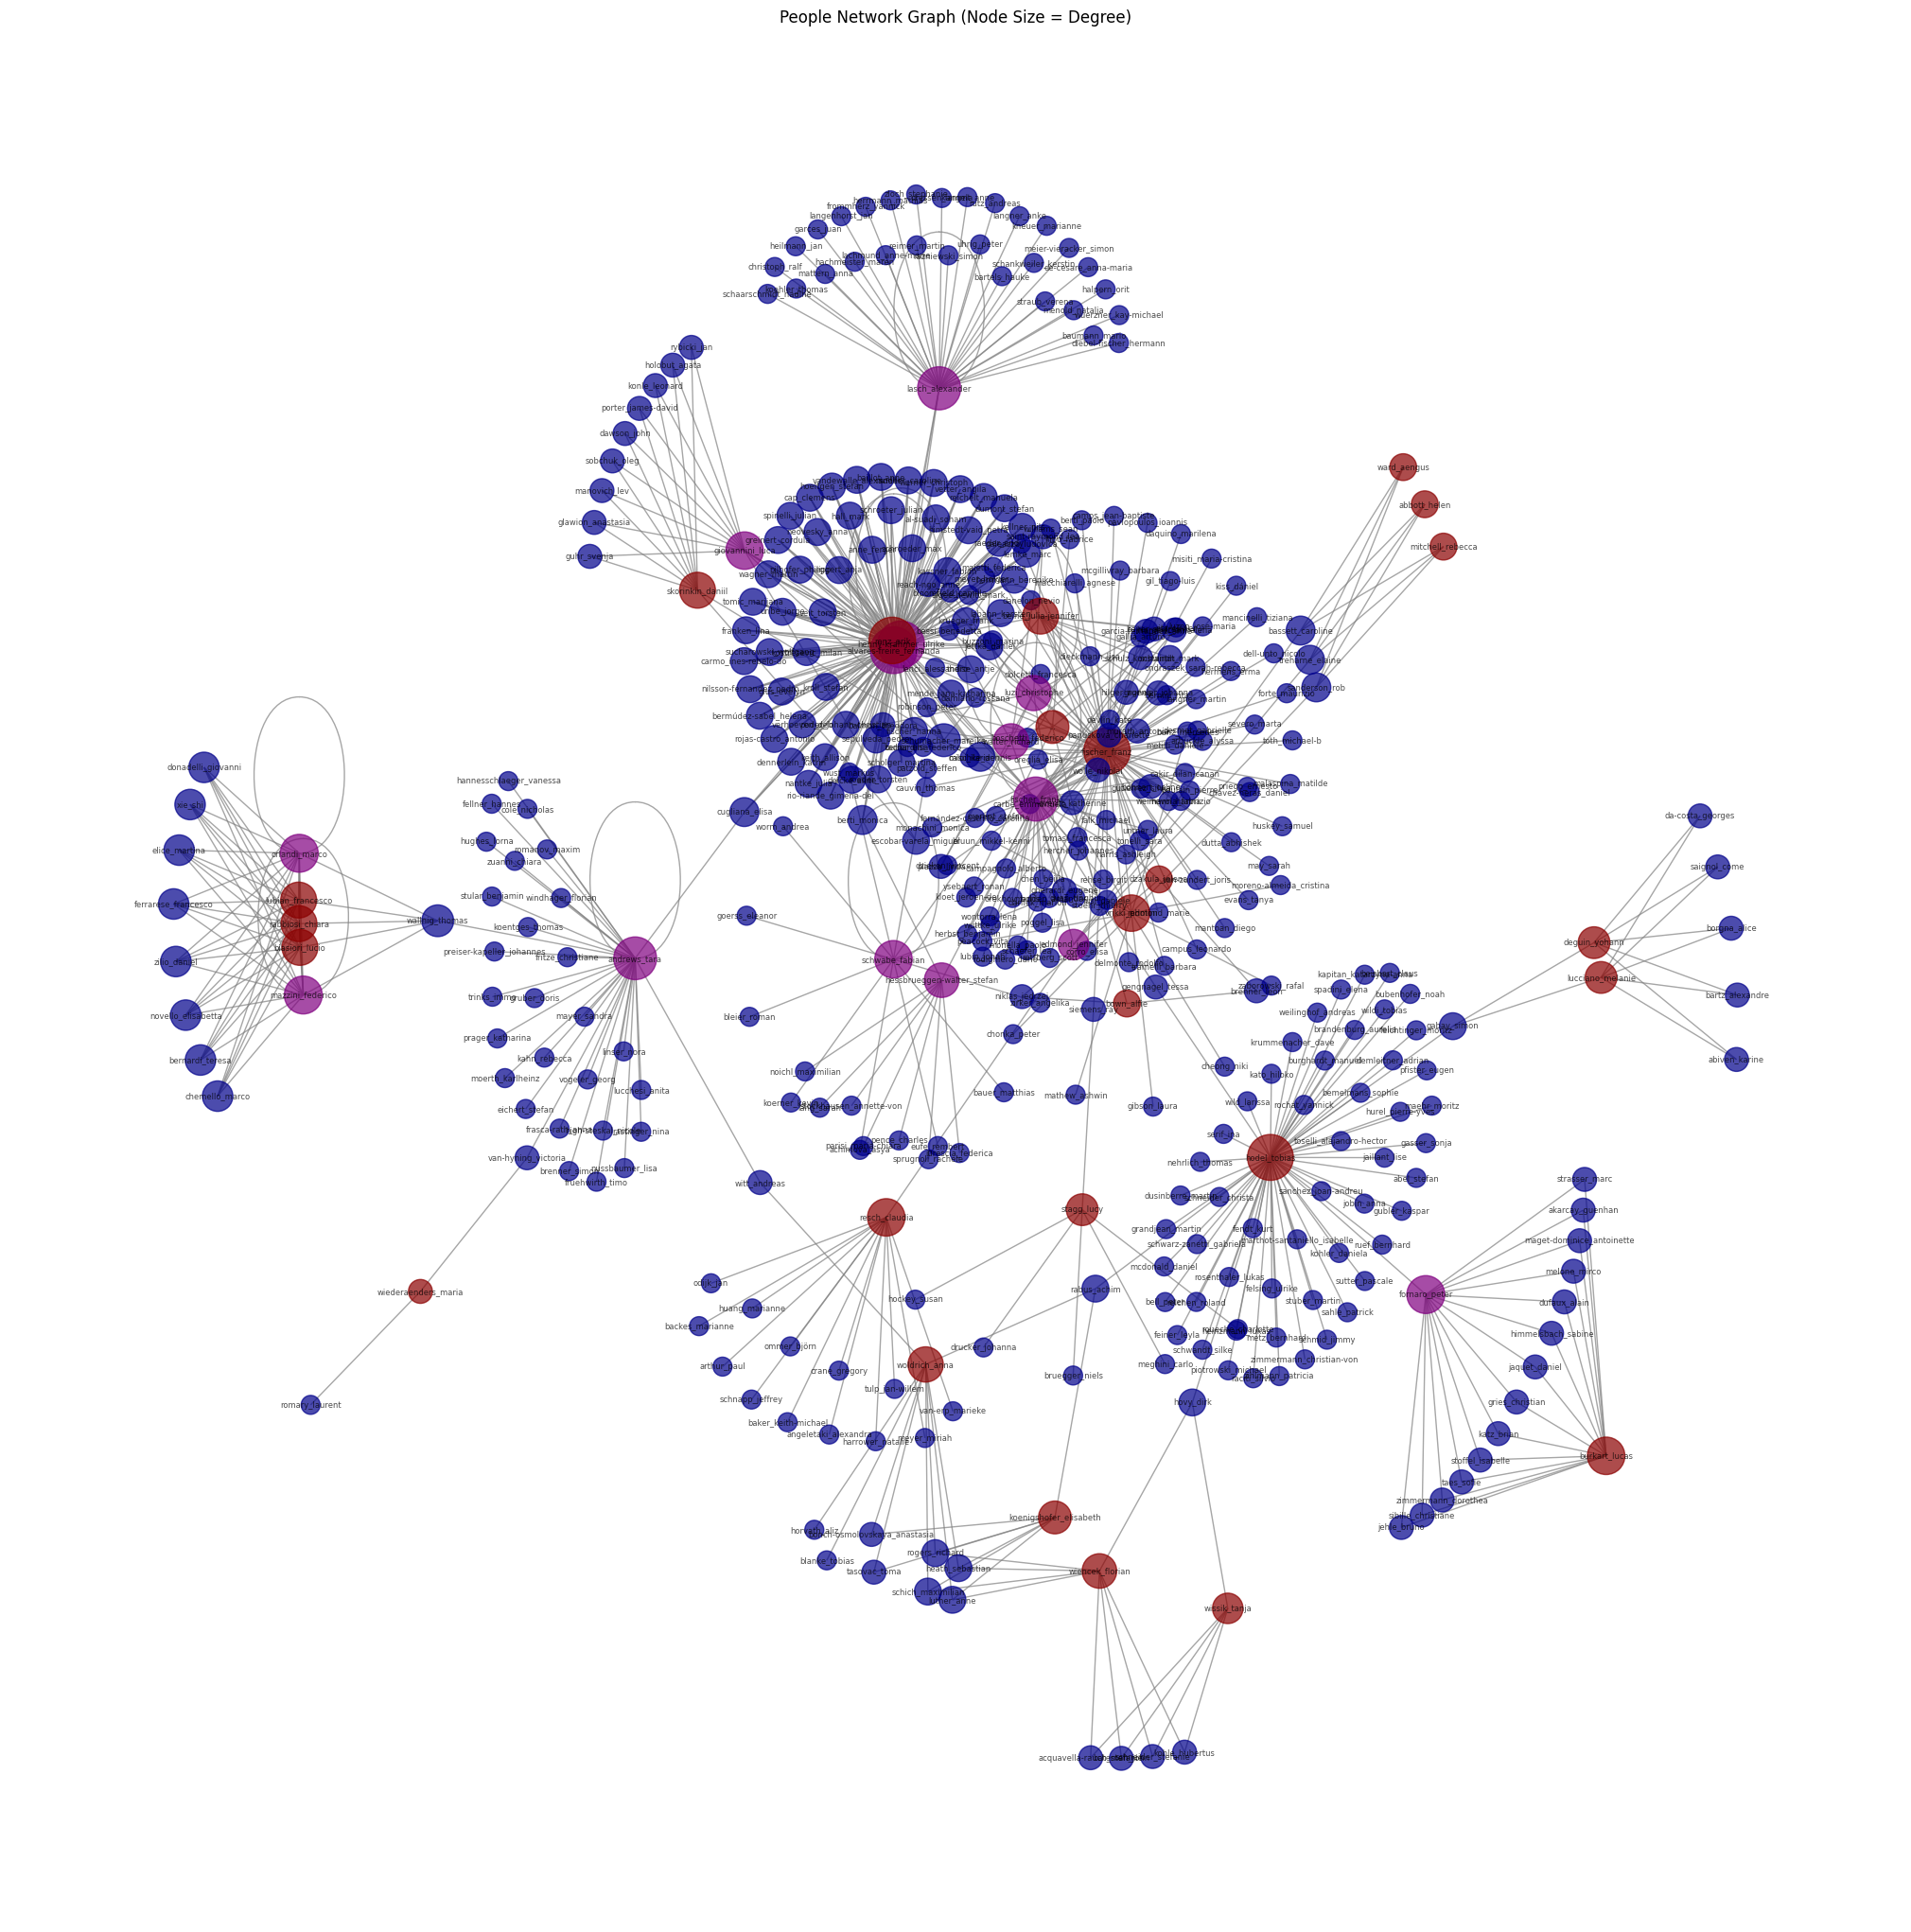

In [188]:
node_degree = dict(G.degree())
node_sizes = [np.log(degree + 1) * 300 for degree in node_degree.values()]  # Log scaling


# Draw Graph
plt.figure(figsize=(20, 20))
pos = nx.kamada_kawai_layout(G, scale=4)  # Try 3 or 4 if needed

nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray",
        node_size=node_sizes, font_size=6, alpha=0.7)

plt.title("People Network Graph (Node Size = Degree)")
plt.show()


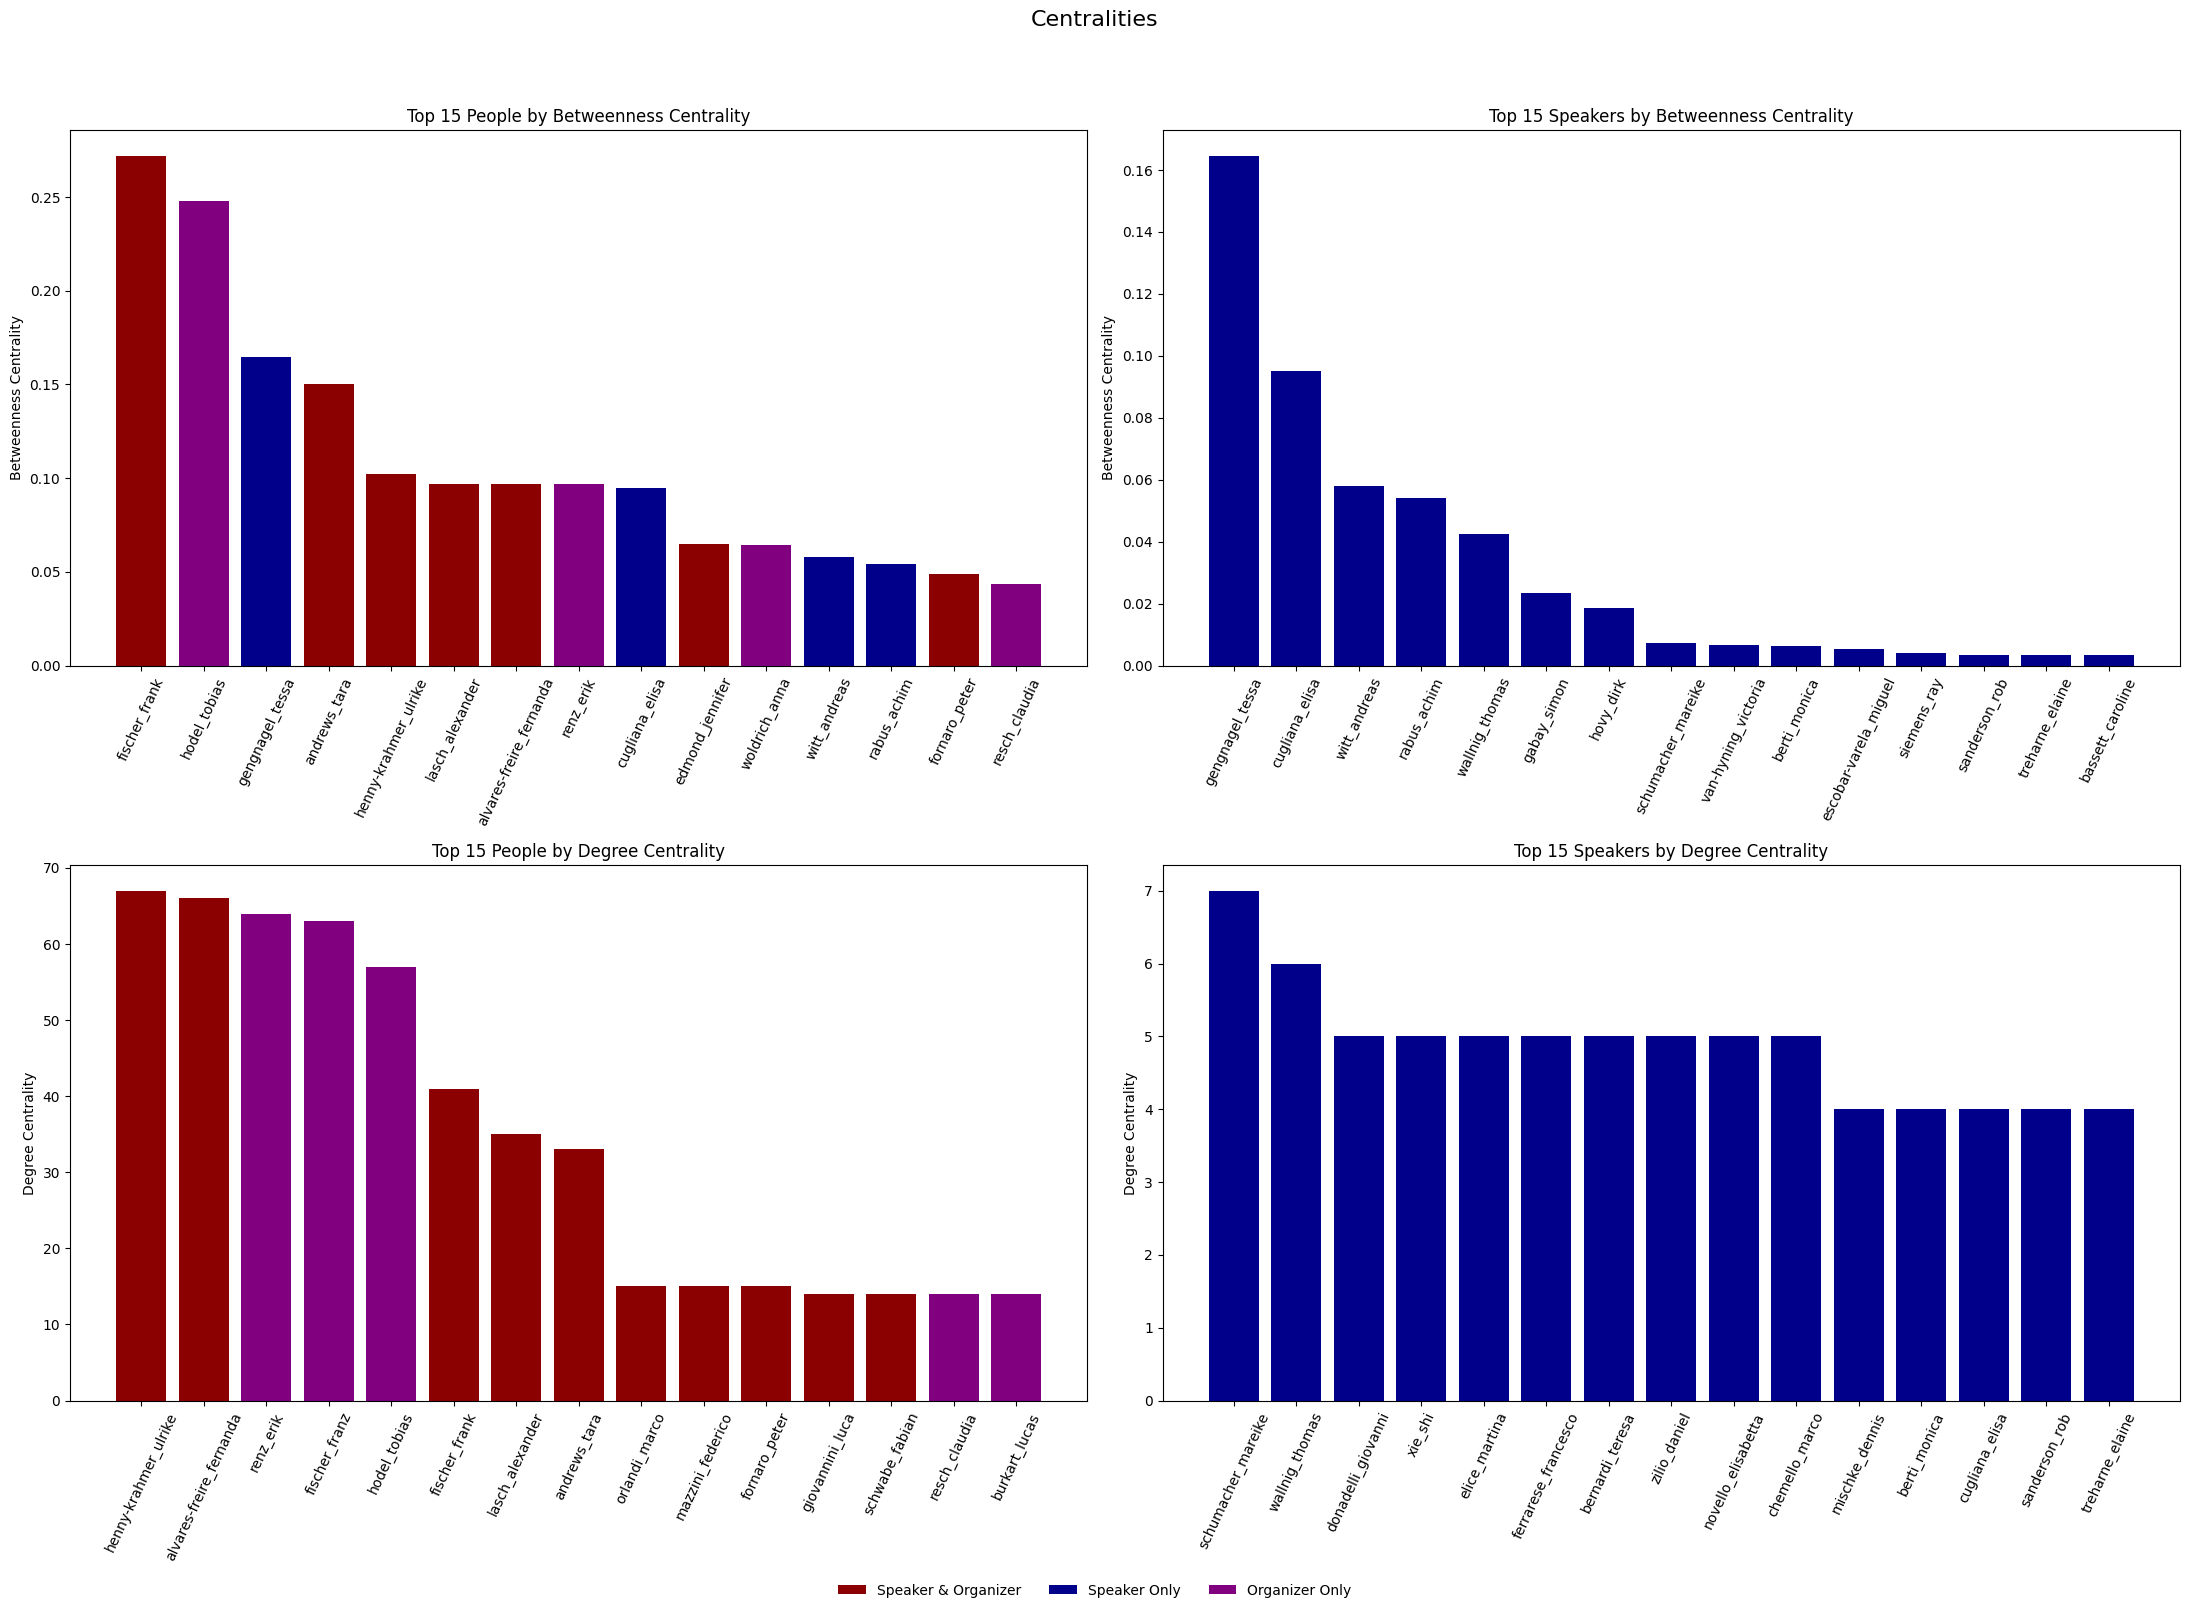

In [ ]:
# betweenness centrality
centrality = nx.betweenness_centrality(G)

# Roles
speakers = set(people_net['speaker'].dropna().str.strip())
organizers = set(people_net['TermOrganizers'].dropna().str.strip())
exclusive_speakers = speakers - organizers

# Top 15 betweenness centralities
top_betweenness = sorted(centrality.items(), 
                     key=lambda x: x[1], 
                     reverse=True)[:15]

exclusive_betweenness = [(name, val) for name, 
                     val in centrality.items() if name in exclusive_speakers]

top_speakers_betweenness = sorted(exclusive_betweenness, 
                       key=lambda x: x[1], 
                       reverse=True)[:15]

# 2x2 subplot layout
fig, axs = plt.subplots(2,
                        2, 
                        figsize=(22, 16))
fig.suptitle('Centralities', fontsize=16)


# --- Plot 1: Betweenness Centralities---
names, values = zip(*top_betweenness)
colors = []

for name in names:
    is_speaker = name in speakers
    is_organizer = name in organizers
    if is_speaker and is_organizer:
        colors.append("darkred")
    elif is_speaker:
        colors.append("darkblue")
    elif is_organizer:
        colors.append("purple")
    else:
        colors.append("gray")

axs[0, 0].bar(names, values, 
              color=colors)
axs[0, 0].set_title("Top 15 People by Betweenness Centrality")
axs[0, 0].tick_params(axis='x', 
                      rotation=65)
axs[0, 0].set_ylabel('Betweenness Centrality')

# --- Plot 2: only speakers ---
names, values = zip(*top_speakers_betweenness)
axs[0, 1].bar(names, values, color='darkblue')
axs[0, 1].set_title("Top 15 Speakers by Betweenness Centrality")
axs[0, 1].tick_params(axis='x', 
                      rotation=65)
axs[0, 1].set_ylabel('Betweenness Centrality')

# --- Plot 3: Top 15 people by degree ---
degree_data = sorted(G.degree(), 
                    key=lambda x: x[1], 
                    reverse=True)[:15]

names, degrees = zip(*degree_data)

colors_deg = []
for name in names:
    is_speaker = name in speakers
    is_organizer = name in organizers
    if is_speaker and is_organizer:
        colors_deg.append("darkred")
    elif is_speaker:
        colors_deg.append("darkblue")
    elif is_organizer:
        colors_deg.append("purple")
    else:
        colors_deg.append("gray")

axs[1, 0].bar(names,
              degrees,
              color=colors_deg)

axs[1, 0].set_title("Top 15 People by Degree Centrality")
axs[1, 0].tick_params(axis='x', 
                      rotation=65)
axs[1, 0].set_ylabel('Degree Centrality')

# --- Plot 4: only speakers by degree ---
exclusive_speaker_degrees = [(node, deg) for node, deg in G.degree() if node in exclusive_speakers]
top_exclusive_deg = sorted(exclusive_speaker_degrees, 
                           key=lambda x: x[1], 
                           reverse=True)[:15]
names, degrees = zip(*top_exclusive_deg)

axs[1, 1].bar(names, degrees, color='darkblue')
axs[1, 1].set_title("Top 15 Speakers by Degree Centrality")
axs[1, 1].tick_params(axis='x', 
                      rotation=65)
axs[1, 1].set_ylabel('Degree Centrality')



plt.tight_layout(rect=[0, 
                       0, 
                       1, 
                       0.95])  
from matplotlib.patches import Patch


legend_elements = [
    Patch(facecolor='darkred', label='Speaker & Organizer'),
    Patch(facecolor='darkblue', label='Speaker Only'),
    Patch(facecolor='purple', label='Organizer Only')
]


fig.legend(handles=legend_elements,
           loc='lower center',
           ncol=3,
           fontsize='medium',
           frameon=False,
           bbox_to_anchor=(0.5, -0.02)) 

# plt.tight_layout()
plt.savefig("Data/people_centralities.png", bbox_inches='tight', dpi=300)

plt.show()


In [ ]:
# Global clustering coefficient

print(nx.transitivity(G))

0.14619024985017257


moderate clustering of ~14.61% of possible triangular relationships

In [ ]:
node_name = "henny-krahmer_ulrike"  # Replace with the node name you want to check
edges_with_data = list(G.edges(node_name, data=True))

print(f"Edges with attributes for '{node_name}':")
for edge in edges_with_data:
    print(edge)  


Edges with attributes for 'henny-krahmer_ulrike':
('henny-krahmer_ulrike', 'henny-krahmer_ulrike', {'edge_id': 'ls10_t5_l4', 'width': 1})
('henny-krahmer_ulrike', 'jettka_daniel', {'edge_id': 'ls10_t1_l2', 'width': 1})
('henny-krahmer_ulrike', 'anne_ferger', {'edge_id': 'ls10_t1_l2', 'width': 1})
('henny-krahmer_ulrike', 'nantke_julia', {'edge_id': 'ls10_t1_l3', 'width': 1})
('henny-krahmer_ulrike', 'roeder_torsten', {'edge_id': 'ls10_t1_l4', 'width': 1})
('henny-krahmer_ulrike', 'alvares-freire_fernanda', {'edge_id': 'ls10_t5_l4', 'width': 1})
('henny-krahmer_ulrike', 'mischke_dennis', {'edge_id': 'ls10_t1_l6', 'width': 1})
('henny-krahmer_ulrike', 'bermúdez-sabel_helena', {'edge_id': 'ls10_t1_l7', 'width': 1})
('henny-krahmer_ulrike', 'kassner_fabian', {'edge_id': 'ls10_t5_l5', 'width': 1})
('henny-krahmer_ulrike', 'krueger_frank', {'edge_id': 'ls10_t3_l4', 'width': 1})
('henny-krahmer_ulrike', 'theise_antje', {'edge_id': 'ls10_t1_l9', 'width': 1})
('henny-krahmer_ulrike', 'schroeder

## Network 2: Institutions-Institutions

In [228]:
df_institutions_net = df[['SeriesPlace', 'LectureId', 'LectureSpeaker']].copy()
df_institutions_net.rename(columns={'LectureId': 'EdgeId'}, inplace=True)


def expand_institutions(row):
    speaker = row['LectureSpeaker']
    institutions = re.findall(r'\((.*?)\)', speaker)
    
    if institutions:

        split_insts = institutions[0].split()
        return [
            {
                'SeriesPlace': row['SeriesPlace'],
                'EdgeId': f"{row['EdgeId']}{chr(97 + i)}",  # adds 'a', 'b'
                'LectureSpeaker': inst.strip()
            }
            for i, inst in enumerate(split_insts)
        ]
    else:
        
        return [{
            'SeriesPlace': row['SeriesPlace'],
            'EdgeId': row['EdgeId'],
            'LectureSpeaker': speaker
        }]


expanded_rows = df_institutions_net.apply(expand_institutions, axis=1)
df_institutions_net = pd.DataFrame([item for sublist in expanded_rows.dropna() for item in sublist])


def expand_places(row):
    places = row['SeriesPlace'].split()
    return [
        {
            'SeriesPlace': place.strip(),
            'EdgeId': f"{chr(97 + i)}{row['EdgeId']}",  # adds 'a' or 'b' before EdgeId
            'LectureSpeaker': row['LectureSpeaker']
        }
        for i, place in enumerate(places)
    ]


expanded_place_rows = df_institutions_net.apply(expand_places, axis=1)
df_institutions_net = pd.DataFrame([item for sublist in expanded_place_rows for item in sublist])

df_institutions_net


SeriesPlace        EdgeId     LectureSpeaker
0        padova   als1_t1_l1a           uni-wien
1        padova   als1_t1_l2a         uni-padova
2        padova   als1_t1_l2b  museum-uni-padova
3        padova   als1_t1_l3a    uni-sun-yat-sen
4        padova   als1_t1_l4a         uni-padova
..          ...           ...                ...
836  birmingham  bls30_t1_l1a           uni-yale
837      dublin  als30_t1_l2a       uni-stanford
838  birmingham  bls30_t1_l2a       uni-stanford
839      dublin  als30_t1_l3a      uni-cambridge
840  birmingham  bls30_t1_l3a      uni-cambridge

[841 rows x 3 columns]

In [229]:
df_institutions_net['SeriesPlace'].unique()

array(['padova', 'venezia', 'paris', 'rouen', 'corte', 'rostock',
       'dresden', 'berlin', 'tuebingen', 'potsdam', 'wien', 'bern',
       'basel', 'london', 'dublin', 'birmingham'], dtype=object)

In [ ]:
orga_dict = {'padova':'uni-padova', 
             'venezia':'uni-venezia', 
             'paris':'uni-paris-cite', 
             'rouen':'uni-rouen',
             'corte':'uni-corse',
             'rostock':'uni-rostock',
            'dresden':'uni-dresden', 
            'berlin':'bbaw', 
            'tuebingen':'uni-tuebingen', 
            'potsdam':'uni-potsdam', 
            'wien22':'uni-wien',
            'wien23':'acdh-ch', 
            'bern':'uni-bern',
            'basel':'uni-basel', 
            'london27':'uni-london-ucl', 
            'london28':'uni-london-kcl', 
            'london29':'uni-london-kcl', 
            'dublin':'uni-trinity-dublin', 
            'birmingham':'uni-birmingham'}

def resolve_seriesplace(row):
    place = row['SeriesPlace']
    
    # 'wien' and 'london'
    if place in ['wien', 'london']:
        match = re.search(r'ls(\d+)', row['EdgeId'])
        if match:
            key = f"{place}{match.group(1)}"
            return orga_dict.get(key, place)  # fallback 
        else:
            return place  # fallback 
    else:
        return orga_dict.get(place, place)  

df_institutions_net['SeriesPlace'] = df_institutions_net.apply(resolve_seriesplace, axis=1)
df_institutions_net


SeriesPlace        EdgeId     LectureSpeaker
0            uni-padova   als1_t1_l1a           uni-wien
1            uni-padova   als1_t1_l2a         uni-padova
2            uni-padova   als1_t1_l2b  museum-uni-padova
3            uni-padova   als1_t1_l3a    uni-sun-yat-sen
4            uni-padova   als1_t1_l4a         uni-padova
..                  ...           ...                ...
836      uni-birmingham  bls30_t1_l1a           uni-yale
837  uni-trinity-dublin  als30_t1_l2a       uni-stanford
838      uni-birmingham  bls30_t1_l2a       uni-stanford
839  uni-trinity-dublin  als30_t1_l3a      uni-cambridge
840      uni-birmingham  bls30_t1_l3a      uni-cambridge

[841 rows x 3 columns]

In [233]:
Gi = nx.DiGraph()

for _, row in df_institutions_net.iterrows():
    source = row['LectureSpeaker']      # speaker's institution
    target = row['SeriesPlace']         # hosting institution
    edge_id = row['EdgeId']

    Gi.add_edge(source, target, edge_id=edge_id)

print("Directed graph:")
print(f"Nodes: {Gi.number_of_nodes()}")
print(f"Edges: {Gi.number_of_edges()}")

Directed graph:
Nodes: 198
Edges: 256


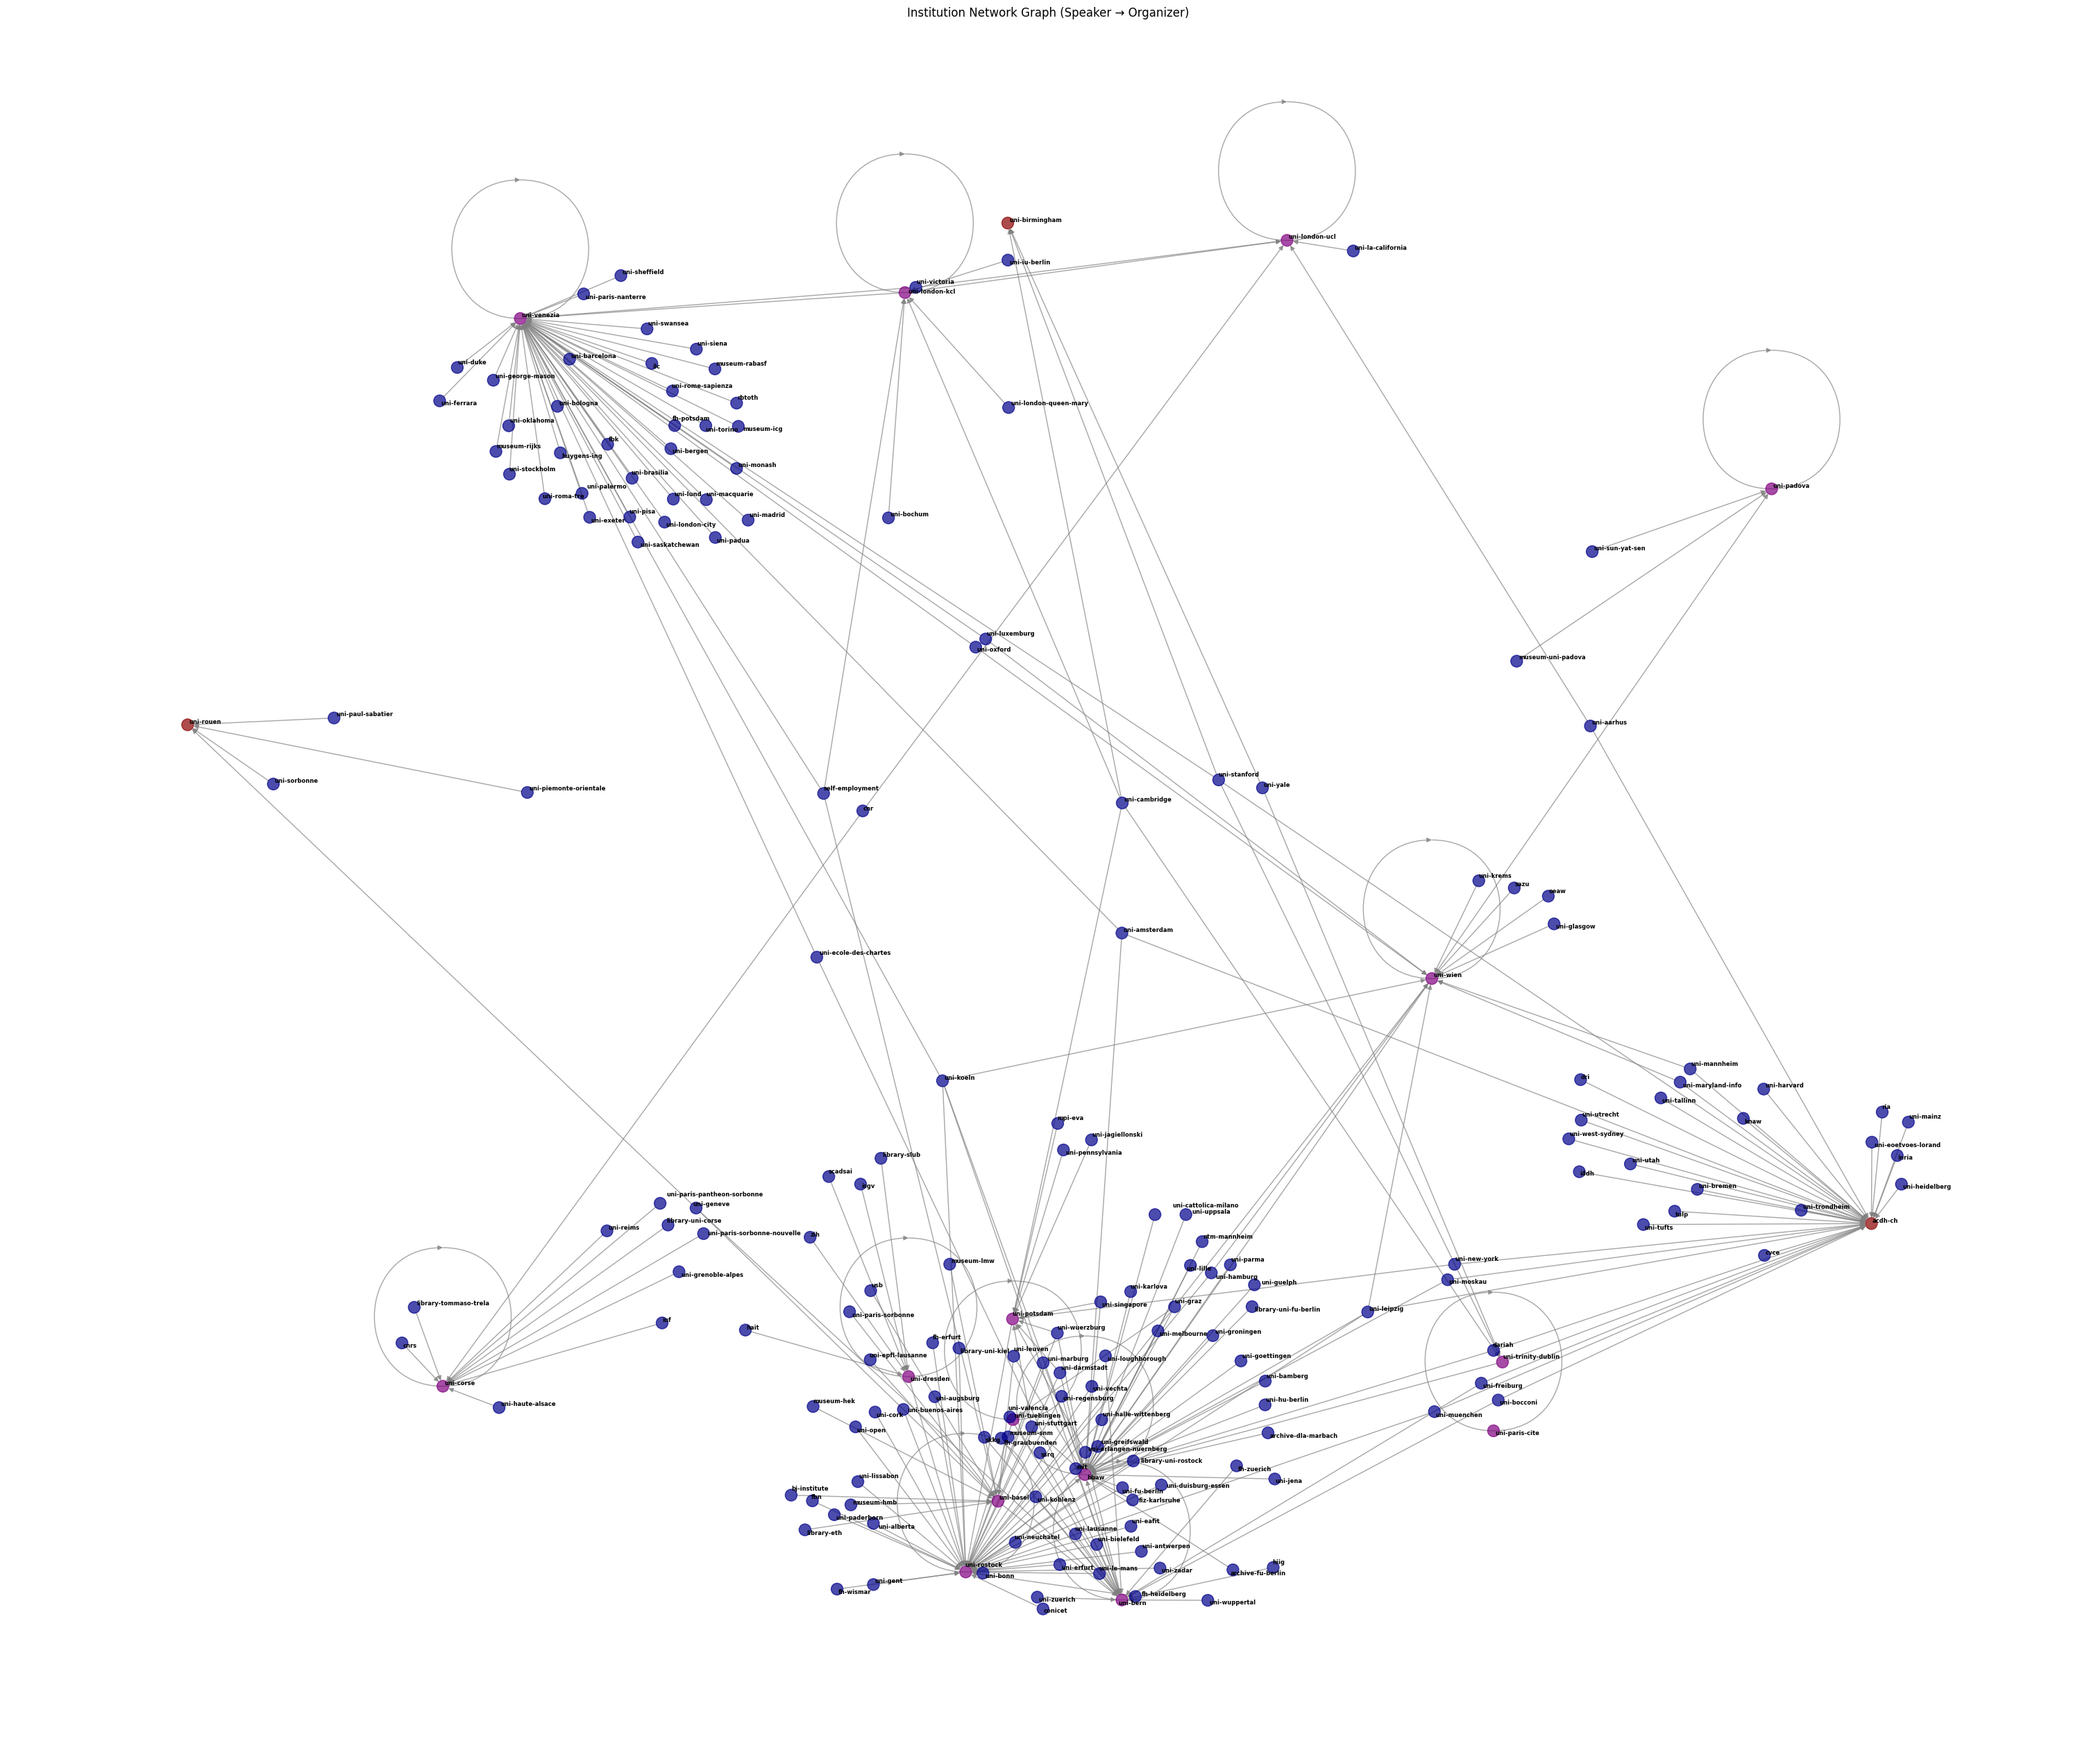

In [237]:
speakers = set(df_institutions_net['LectureSpeaker'].dropna())
organizers = set(df_institutions_net['SeriesPlace'].dropna())

node_colors = []
for node in Gi.nodes():
    is_speaker = node in speakers
    is_organizer = node in organizers

    if is_speaker and is_organizer:
        node_colors.append("purple")  # both
    elif is_speaker:
        node_colors.append("darkblue")
    elif is_organizer:
        node_colors.append("darkred")
    else:
        node_colors.append("gray")  # fallback

# Plotting
plt.figure(figsize=(30, 25))
# pos = nx.kamada_kawai_layout(Gi, scale=20.0)
pos = nx.spring_layout(Gi, k=0.3, iterations=100, seed=42)

nx.draw(Gi,
        pos,
        with_labels=False,
        node_color=node_colors,
        edge_color="gray",
        node_size=150,
        alpha=0.7)

# text labels
text_labels = [plt.text(x, y, node, fontsize=6, fontweight='bold') for node, (x, y) in pos.items()]
adjust_text(text_labels)

plt.title("Institution Network Graph (Speaker → Organizer)")
plt.savefig("Data/institution_network_graph.svg", bbox_inches="tight")
# plt.show()


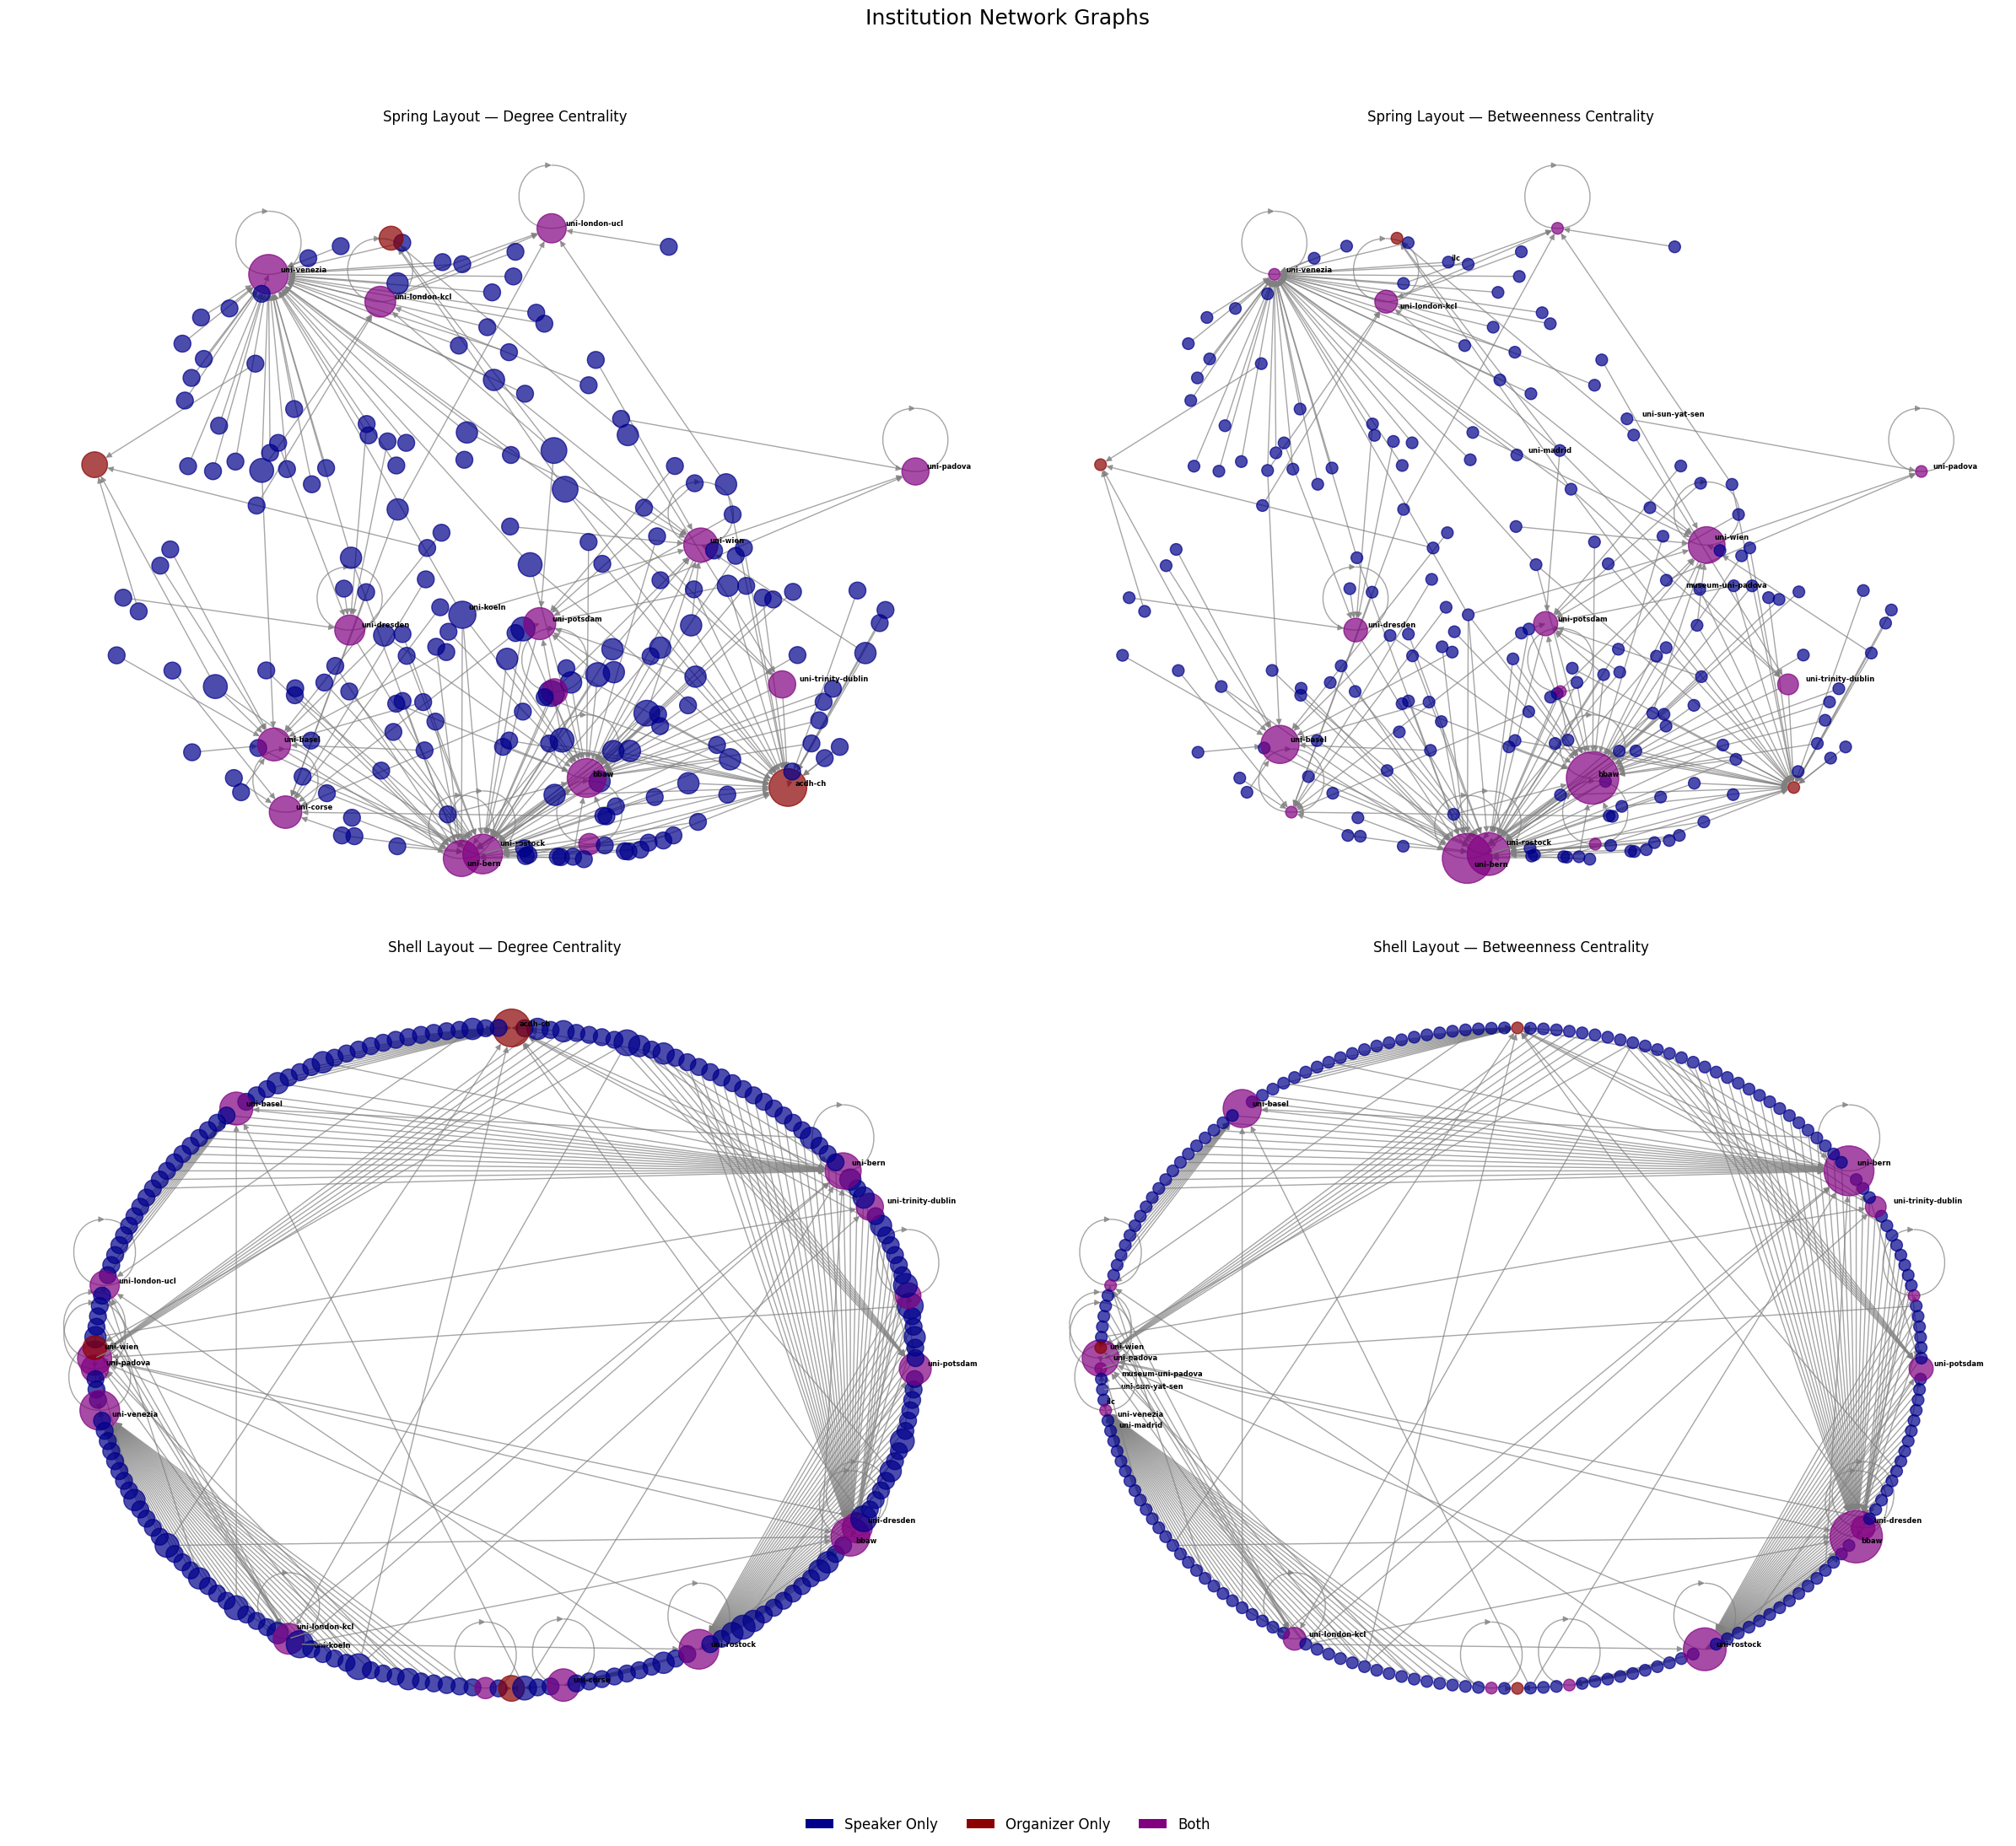

In [254]:
# ---- Centrality Measures ----
degree_centrality = dict(Gi.degree())
betweenness_centrality = nx.betweenness_centrality(Gi)


speakers = set(df_institutions_net['LectureSpeaker'].dropna())
organizers = set(df_institutions_net['SeriesPlace'].dropna())

node_colors = []
for node in Gi.nodes():
    is_speaker = node in speakers
    is_organizer = node in organizers
    if is_speaker and is_organizer:
        node_colors.append("purple")
    elif is_speaker:
        node_colors.append("darkblue")
    elif is_organizer:
        node_colors.append("darkred")
    else:
        node_colors.append("gray")

# ---- Node Sizes ----
# Deg. log scale
degree_sizes = [np.log(degree_centrality[node] + 1) * 300 for node in Gi.nodes()]

# Bet. min-max scale
min_b, max_b = min(betweenness_centrality.values()), max(betweenness_centrality.values())
betweenness_sizes = [
    100 + (betweenness_centrality[node] - min_b) / (max_b - min_b) * 1900 if max_b > min_b else 500
    for node in Gi.nodes()
]

spring_pos = nx.spring_layout(Gi, k=1.2, iterations=200, seed=42)
shell_pos = nx.shell_layout(Gi)

# top 15
top_degree_nodes = [node for node, _ in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:15]]
top_betweenness_nodes = [node for node, _ in sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:15]]


fig, axs = plt.subplots(2, 2, figsize=(24, 22))
fig.suptitle("Institution Network Graphs", fontsize=18)


def draw_graph(ax, pos, sizes, title, highlight_nodes):
    ax.set_title(title)
    nx.draw(Gi, pos,
            node_color=node_colors,
            edge_color="gray",
            node_size=sizes,
            with_labels=False,
            alpha=0.7,
            ax=ax)


    texts = []
    for node in highlight_nodes:
        if node in pos:
            x, y = pos[node]
            texts.append(ax.text(x, y, node, fontsize=6, fontweight='bold'))

    adjust_text(texts, ax=ax, expand_text=(1.1, 1.2), force_text=0.3, arrowprops=dict(arrowstyle='-', color='gray'))


draw_graph(axs[0, 0], spring_pos, degree_sizes, "Spring Layout — Degree Centrality", top_degree_nodes)
draw_graph(axs[0, 1], spring_pos, betweenness_sizes, "Spring Layout — Betweenness Centrality", top_betweenness_nodes)
draw_graph(axs[1, 0], shell_pos, degree_sizes, "Shell Layout — Degree Centrality", top_degree_nodes)
draw_graph(axs[1, 1], shell_pos, betweenness_sizes, "Shell Layout — Betweenness Centrality", top_betweenness_nodes)


legend_elements = [
    Patch(facecolor='darkblue', label='Speaker Only'),
    Patch(facecolor='darkred', label='Organizer Only'),
    Patch(facecolor='purple', label='Both')
]
fig.legend(handles=legend_elements,
           loc='lower center',
           ncol=3,
           fontsize='large',
           frameon=False,
           bbox_to_anchor=(0.5, -0.01))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("Data/institution_degree_shellandspring.svg", bbox_inches='tight', dpi=300)
plt.show()



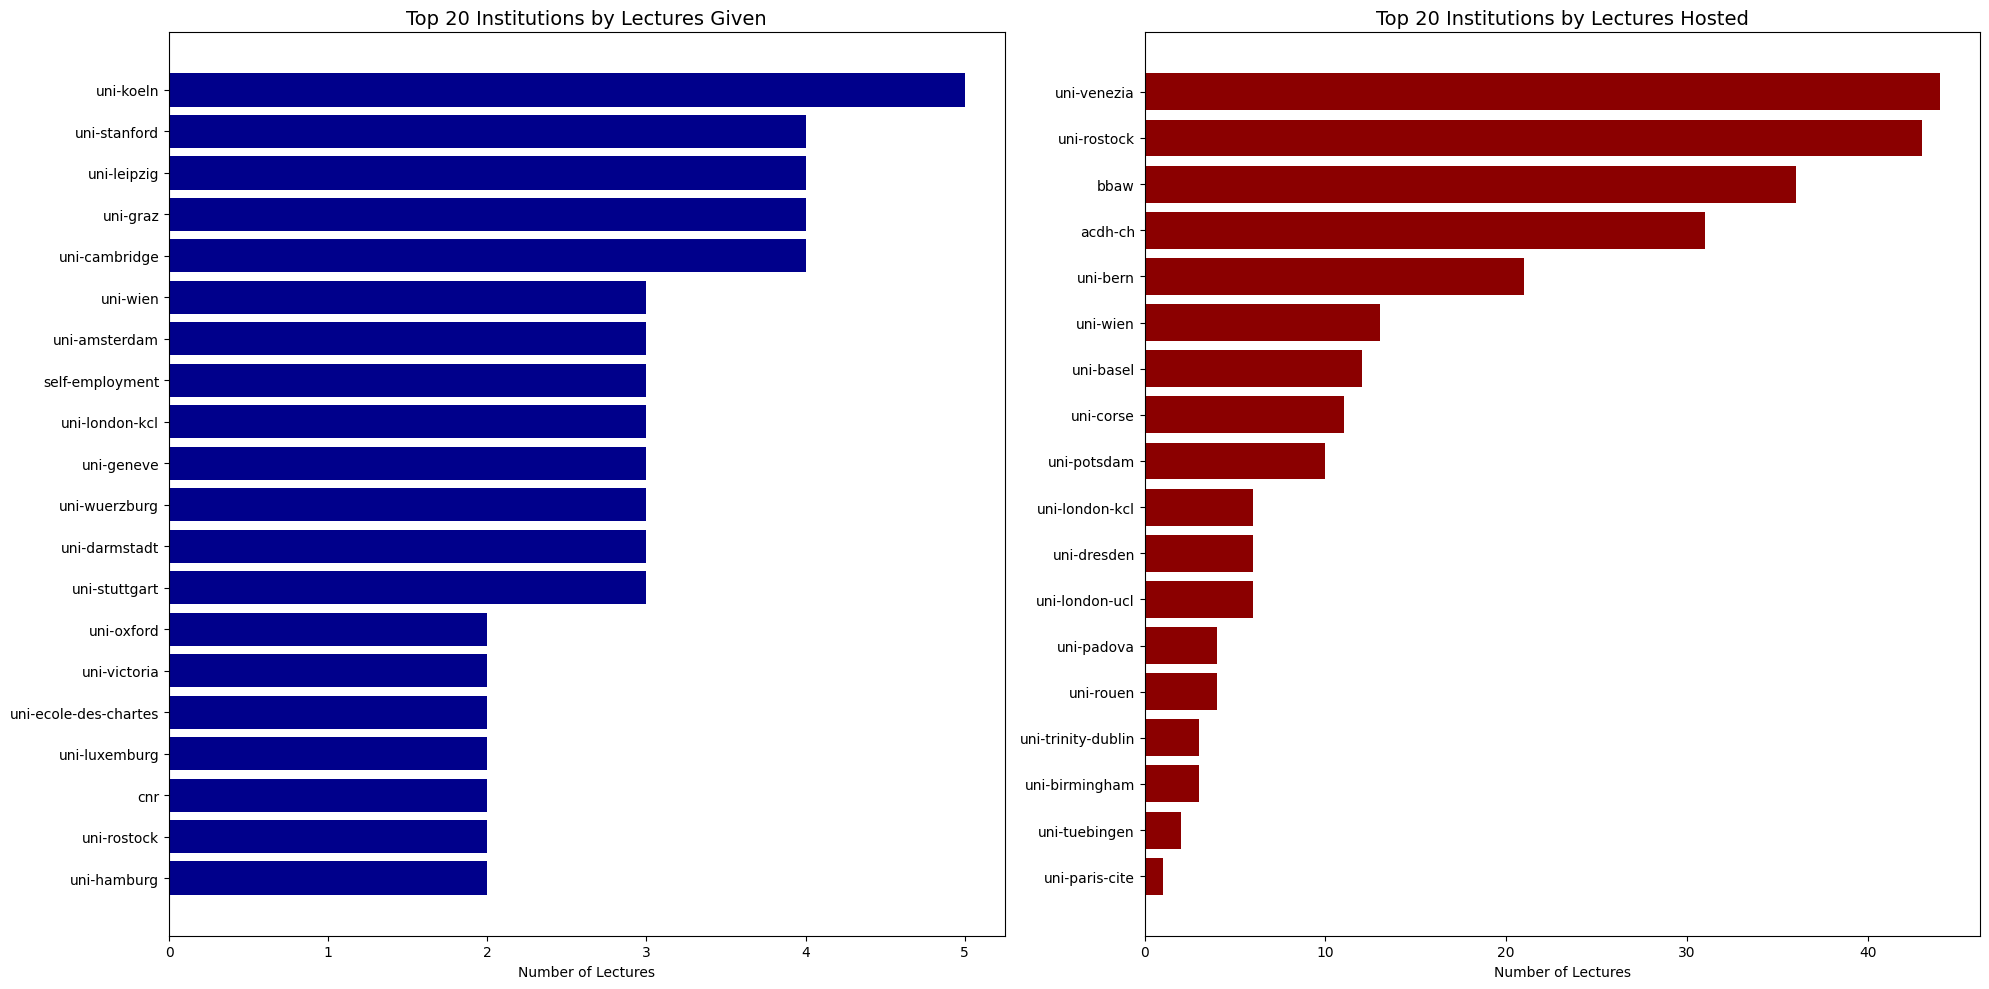

In [243]:
speaker_counts = {node: Gi.out_degree(node) for node in Gi.nodes if Gi.out_degree(node) > 0}
organizer_counts = {node: Gi.in_degree(node) for node in Gi.nodes if Gi.in_degree(node) > 0}

top_speakers = sorted(speaker_counts.items(), key=lambda x: x[1], reverse=True)[:20]
top_organizers = sorted(organizer_counts.items(), key=lambda x: x[1], reverse=True)[:20]

speaker_names, speaker_values = zip(*top_speakers)
organizer_names, organizer_values = zip(*top_organizers)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))  # 1 row, 2 columns

# Plot 1: Lectures Given
ax1.barh(speaker_names, speaker_values, color='darkblue')
ax1.set_title("Top 20 Institutions by Lectures Given", fontsize=14)
ax1.set_xlabel("Number of Lectures")
ax1.invert_yaxis()

# Plot 2: Lectures Hosted
ax2.barh(organizer_names, organizer_values, color='darkred')
ax2.set_title("Top 20 Institutions by Lectures Hosted", fontsize=14)
ax2.set_xlabel("Number of Lectures")
ax2.invert_yaxis()

plt.tight_layout()

plt.savefig("Data/top20institutions.png", bbox_inches='tight', dpi=300)
plt.show()
